In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import datasets, model_selection, preprocessing, metrics, svm, linear_model


In [2]:

df = pd.read_csv('batelada.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TimeStamp             613 non-null    object 
 1   G100CP2_FT420202      613 non-null    object 
 2   G100CP2_FT420201      613 non-null    object 
 3   G100CP2_PV110001      613 non-null    object 
 4   G100CP2_PV110002      613 non-null    object 
 5   G100CP2_PV110007      613 non-null    object 
 6   G100CP2_LT110003      613 non-null    float64
 7   G100CP2_LIC110003_MV  613 non-null    float64
 8   G100CP2_PV110007.1    613 non-null    object 
 9   G100CP2_FIC420201_SP  613 non-null    object 
 10  G100CP2_FIC420202_SP  613 non-null    object 
 11  G100CPU_M1WT100010    613 non-null    object 
 12  G100CP2_DT420201      613 non-null    object 
 13  G100CP2_PV110003      613 non-null    float64
 14  G100CP2_PV110017      613 non-null    object 
 15  G100CP2_SET110093     6

In [4]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

In [5]:
df = df.replace(['<No Data>', '<Bad Data>'], np.nan)

In [6]:
# Função lambda para remover a vírgula
remove_comma = lambda x: float(str(x).replace(',', '')) if isinstance(x, str) else x

# Aplique a função lambda a todas as colunas do tipo 'object'
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].apply(remove_comma)


In [7]:
df.head()

TimeStamp  G100CP2_FT420202  G100CP2_FT420201  G100CP2_PV110001  \
0 2024-08-01 09:09:00               0.0               0.0               0.0   
1 2024-08-01 09:10:00               0.0               0.0               0.0   
2 2024-08-01 09:11:00               0.0               0.0               0.0   
3 2024-08-01 09:12:00               0.0               0.0               0.0   
4 2024-08-01 09:13:00               0.0               0.0               0.0   

   G100CP2_PV110002  G100CP2_PV110007  G100CP2_LT110003  G100CP2_LIC110003_MV  \
0               0.0               0.0              0.19                  25.0   
1               0.0               0.0              0.19                  25.0   
2               0.0               0.0              0.18                  25.0   
3               0.0               0.0              0.18                  25.0   
4               0.0               0.0              0.17                  25.0   

   G100CP2_PV110007.1  G100CP2_FIC420201_SP  G100CP2_FIC420202_SP  \
0                 0.0                   0.0              26983.12   
1                 0.0                   0.0              26983.12   
2                 0.0                   0.0              26983.12   
3                 0.0                   0.0              26983.12   
4                 0.0                   0.0              26983.12   

   G100CPU_M1WT100010  G100CP2_DT420201  G100CP2_PV110003  G100CP2_PV110017  \
0            200467.0           1434.41             49.71               0.0   
1            200110.0           1434.50             49.71               0.0   
2            199932.0           1434.45             49.71               0.0   
3            199457.0           1434.38             49.71               0.0   
4            199160.0           1434.38             49.71               0.0   

   G100CP2_SET110093  G100CP2_SET110094  G100CP2_FT110003  
0              71.21               37.0               0.0  
1              71.21               37.0               0.0  
2              71.21               37.0               0.0  
3              71.21               37.0               0.0  
4              71.21               37.0               0.0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TimeStamp             613 non-null    datetime64[ns]
 1   G100CP2_FT420202      613 non-null    float64       
 2   G100CP2_FT420201      613 non-null    float64       
 3   G100CP2_PV110001      613 non-null    float64       
 4   G100CP2_PV110002      613 non-null    float64       
 5   G100CP2_PV110007      613 non-null    float64       
 6   G100CP2_LT110003      613 non-null    float64       
 7   G100CP2_LIC110003_MV  613 non-null    float64       
 8   G100CP2_PV110007.1    613 non-null    float64       
 9   G100CP2_FIC420201_SP  613 non-null    float64       
 10  G100CP2_FIC420202_SP  613 non-null    float64       
 11  G100CPU_M1WT100010    613 non-null    float64       
 12  G100CP2_DT420201      613 non-null    float64       
 13  G100CP2_PV110003    

In [8]:
# Dicionário mapeando os códigos para os novos nomes
column_mapping = {
    'G100CP2_FT420202': 'Transmissor de Vazao de H2O',
    'G100CP2_FT420201': 'Transmissor de Vazao FS',
    'G100CP2_PV110001': 'TOTALIZADO BATELADA FS',
    'G100CP2_PV110002': 'TOTALIZADO BATELADA AGUA',
    'G100CP2_PV110007': 'VAZAO DE MOSTO CALCULADA',
    'G100CP2_LT110003': 'Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2',
    'G100CP2_LIC110003_MV': 'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO',
    'G100CP2_PV110007.1': 'VAZAO DE MOSTO CALCULADA',
    'G100CP2_FIC420201_SP': 'Controlador Indicador de Vazao SP ALIMENTACAO DE FS',
    'G100CP2_FIC420202_SP': 'Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO',
    'G100CPU_M1WT100010': 'PESO PRODUTO TANQUE WT-01',
    'G100CP2_DT420201': 'DENSIDADE SAIDA DE FS',
    'G100CP2_PV110003': 'PORCENTAGEM DE FS RELACAO MOSTO',
    'G100CP2_PV110017': 'TOTALIZADO VAZAO DE FS E AGUA',
    'G100CP2_SET110093': 'AFT DO FS FINAL',
    'G100CP2_SET110094' : 'AFT DESEJADA NO MOSTO FINAL',
    'G100CP2_FT110003' : 'Transmissor de Vazao MOSTO ESTERILIZADOR 2'

    
    
}

# Renomeando as colunas no DataFrame
df.rename(columns=column_mapping, inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 18 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   TimeStamp                                                             613 non-null    datetime64[ns]
 1   Transmissor de Vazao de H2O                                           613 non-null    float64       
 2   Transmissor de Vazao FS                                               613 non-null    float64       
 3   TOTALIZADO BATELADA FS                                                613 non-null    float64       
 4   TOTALIZADO BATELADA AGUA                                              613 non-null    float64       
 5   VAZAO DE MOSTO CALCULADA                                              613 non-null    float64       
 6   Transmissor de Nivel TANQUE DE PRE AQUECIM

In [10]:
df.isnull().sum()

TimeStamp                                                               0
Transmissor de Vazao de H2O                                             0
Transmissor de Vazao FS                                                 0
TOTALIZADO BATELADA FS                                                  0
TOTALIZADO BATELADA AGUA                                                0
VAZAO DE MOSTO CALCULADA                                                0
Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2    0
Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO      0
VAZAO DE MOSTO CALCULADA                                                0
Controlador Indicador de Vazao SP ALIMENTACAO DE FS                     0
Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO                  0
PESO PRODUTO TANQUE WT-01                                               0
DENSIDADE SAIDA DE FS                                                   0
PORCENTAGEM DE FS RELACAO MOSTO       

In [11]:
df = df.fillna(df.mean())

In [12]:
df.isnull().sum()

TimeStamp                                                               0
Transmissor de Vazao de H2O                                             0
Transmissor de Vazao FS                                                 0
TOTALIZADO BATELADA FS                                                  0
TOTALIZADO BATELADA AGUA                                                0
VAZAO DE MOSTO CALCULADA                                                0
Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2    0
Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO      0
VAZAO DE MOSTO CALCULADA                                                0
Controlador Indicador de Vazao SP ALIMENTACAO DE FS                     0
Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO                  0
PESO PRODUTO TANQUE WT-01                                               0
DENSIDADE SAIDA DE FS                                                   0
PORCENTAGEM DE FS RELACAO MOSTO       

In [13]:
df.shape

(613, 18)

In [14]:
df.describe()

TimeStamp  Transmissor de Vazao de H2O  \
count                            613                   613.000000   
mean   2024-08-01 14:14:59.999999744                 12281.314176   
min              2024-08-01 09:09:00                     0.000000   
25%              2024-08-01 11:42:00                     0.000000   
50%              2024-08-01 14:15:00                 17160.000000   
75%              2024-08-01 16:48:00                 18396.750000   
max              2024-08-01 19:21:00                 38153.120000   
std                              NaN                  9391.468452   

       Transmissor de Vazao FS  TOTALIZADO BATELADA FS  \
count               613.000000              613.000000   
mean              12365.409494            50478.899576   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%               19290.120000            41673.970000   
75%               20640.250000            93983.020000   
max               22213.620000           126317.000000   
std                9826.297862            46973.239154   

       TOTALIZADO BATELADA AGUA  VAZAO DE MOSTO CALCULADA  \
count                613.000000                613.000000   
mean               44681.256232              32500.177781   
min                    0.000000                  0.000000   
25%                    0.000000              36343.280000   
50%                35931.420000              38275.000000   
75%                82304.160000              40345.330000   
max               122541.990000              46000.000000   
std                42590.193237              14779.539264   

       Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  \
count                                         613.000000                      
mean                                           42.678907                      
min                                             0.160000                      
25%                                            14.410000                      
50%                                            54.170000                      
75%                                            62.800000                      
max                                            68.630000                      
std                                            24.779912                      

       Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
count                                         613.000000                    
mean                                           39.210962                    
min                                            25.000000                    
25%                                            25.000000                    
50%                                            44.180000                    
75%                                            46.930000                    
max                                            59.790000                    
std                                            10.943426                    

       VAZAO DE MOSTO CALCULADA  \
count                613.000000   
mean               32500.177781   
min                    0.000000   
25%                36343.280000   
50%                38275.000000   
75%                40345.330000   
max                46000.000000   
std                14779.539264   

       Controlador Indicador de Vazao SP ALIMENTACAO DE FS  \
count                                         613.000000     
mean                                        12078.379592     
min                                             0.000000     
25%                                             0.000000     
50%                                         19287.120000     
75%                                         20647.500000     
max                                         22211.250000     
std                                         10056.572706     

       Controlador Indicador de Vazao SP AGUARDANDO

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 18 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   TimeStamp                                                             613 non-null    datetime64[ns]
 1   Transmissor de Vazao de H2O                                           613 non-null    float64       
 2   Transmissor de Vazao FS                                               613 non-null    float64       
 3   TOTALIZADO BATELADA FS                                                613 non-null    float64       
 4   TOTALIZADO BATELADA AGUA                                              613 non-null    float64       
 5   VAZAO DE MOSTO CALCULADA                                              613 non-null    float64       
 6   Transmissor de Nivel TANQUE DE PRE AQUECIM

In [16]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

# 1. Distribuição das Variáveis

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


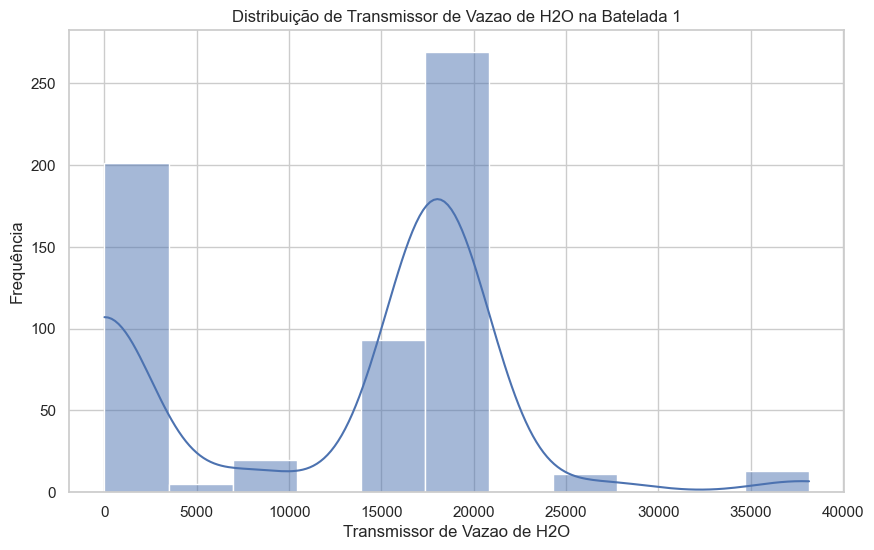

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


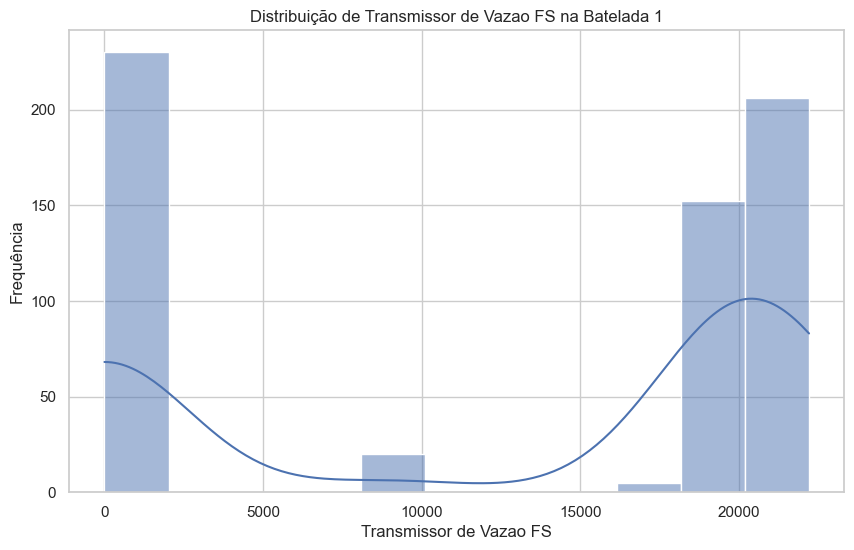

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


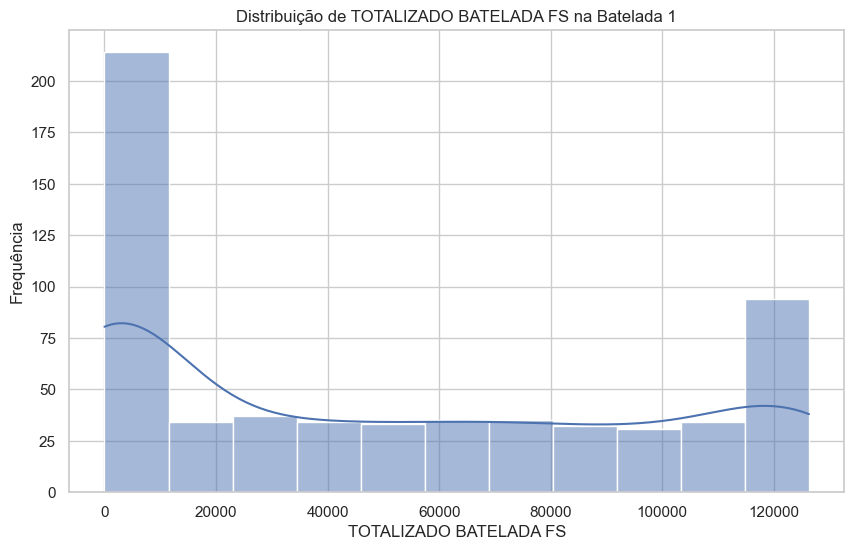

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


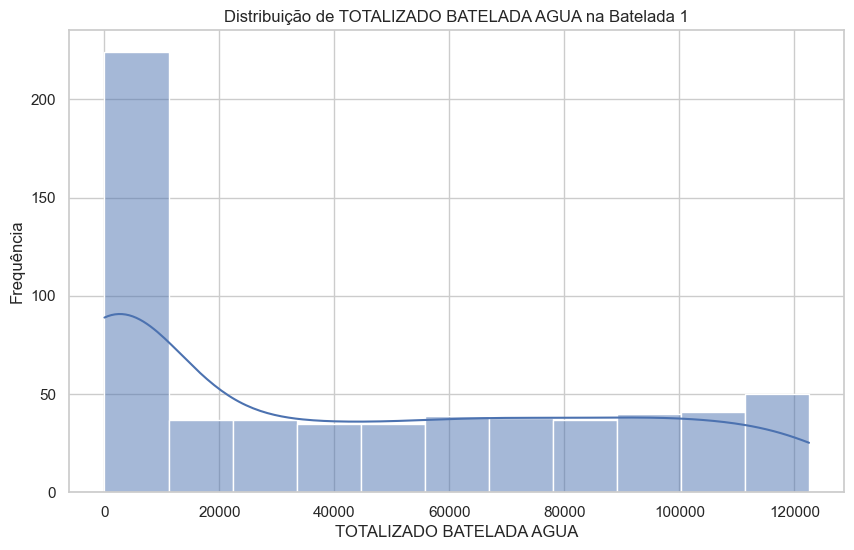

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


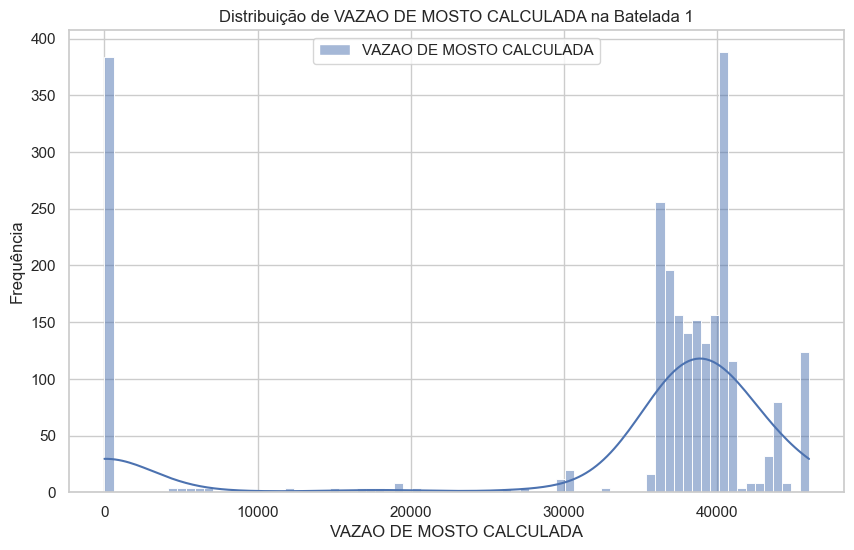

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


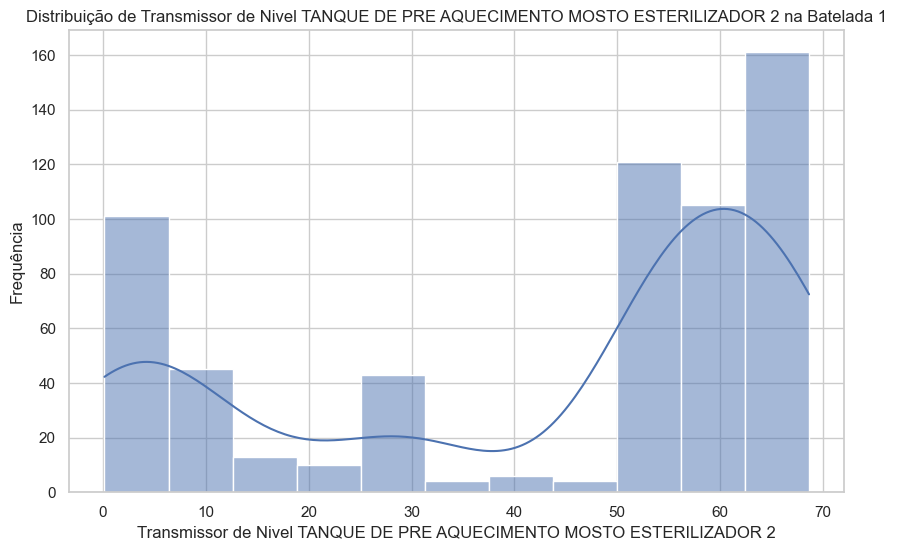

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


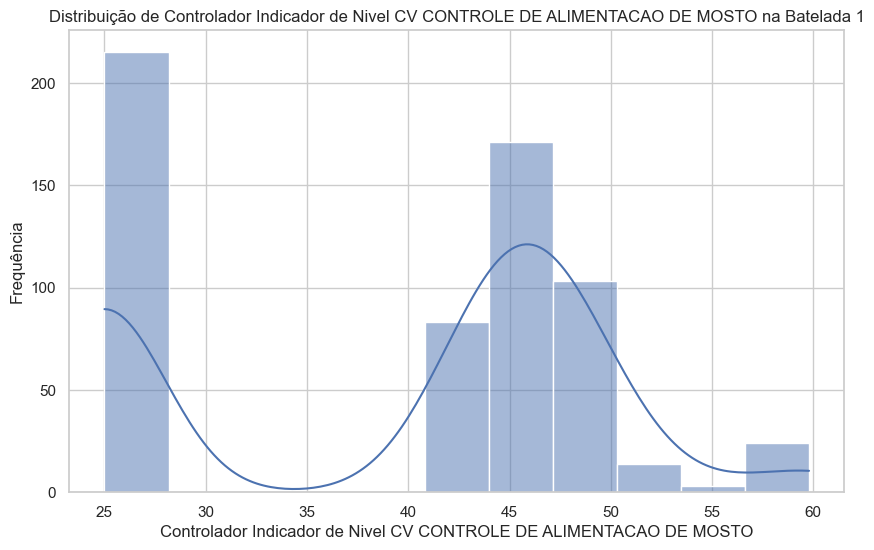

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


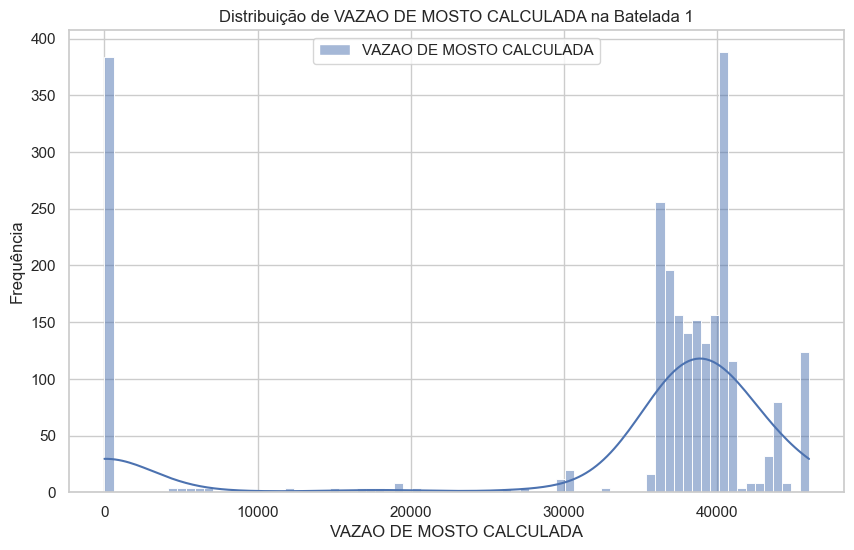

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


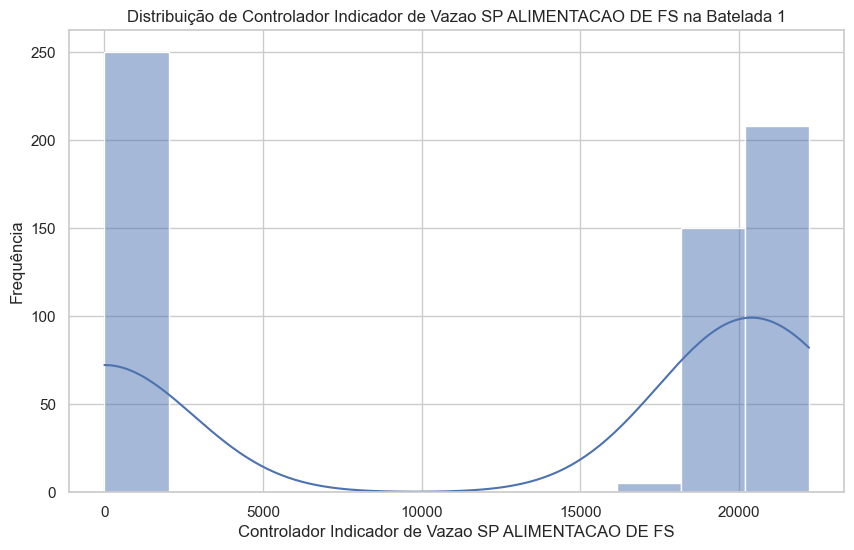

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


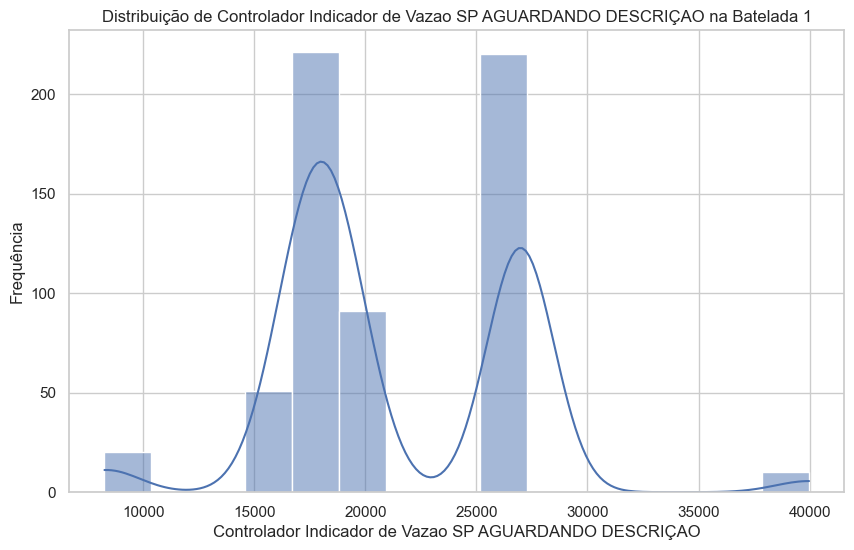

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


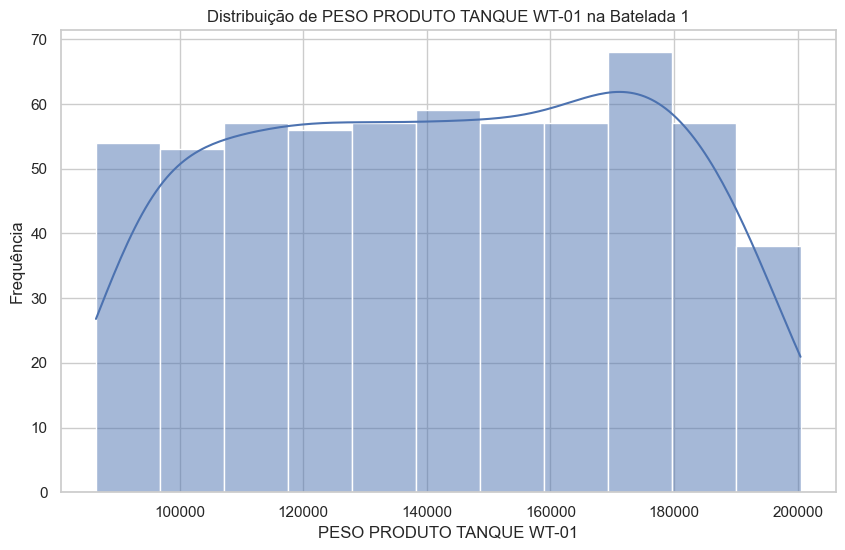

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


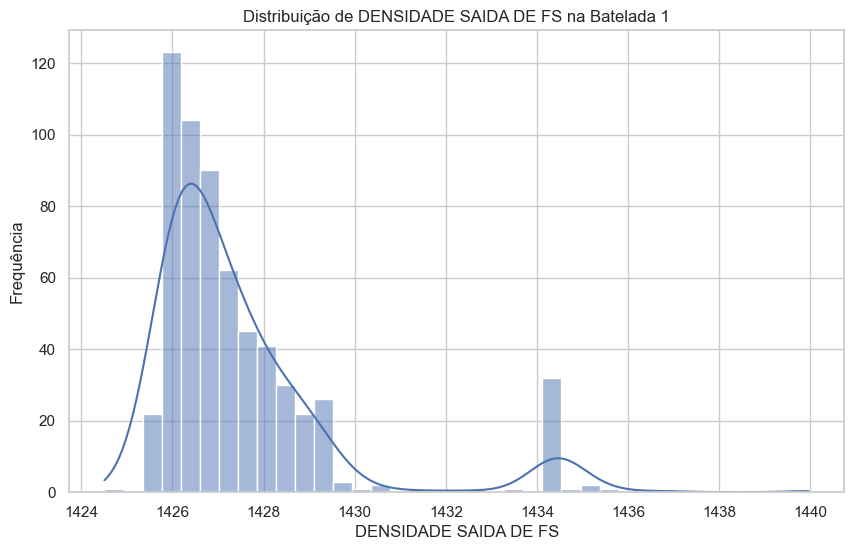

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


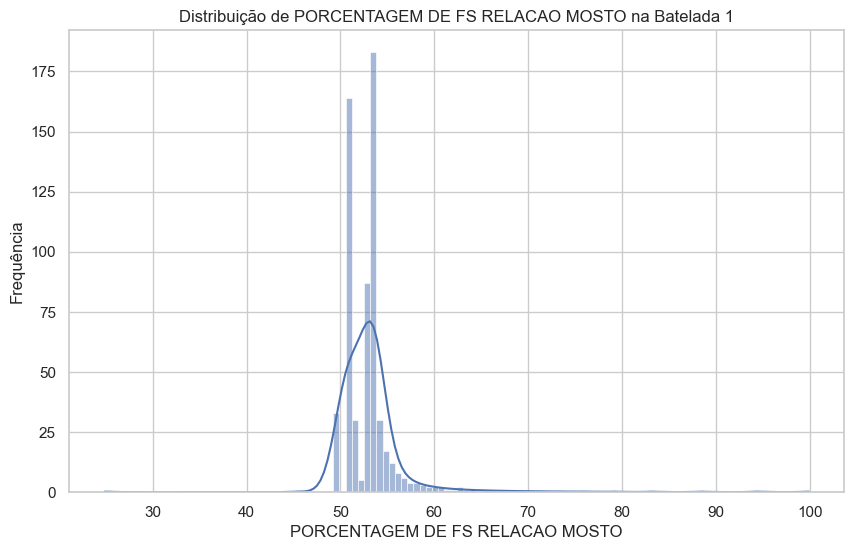

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


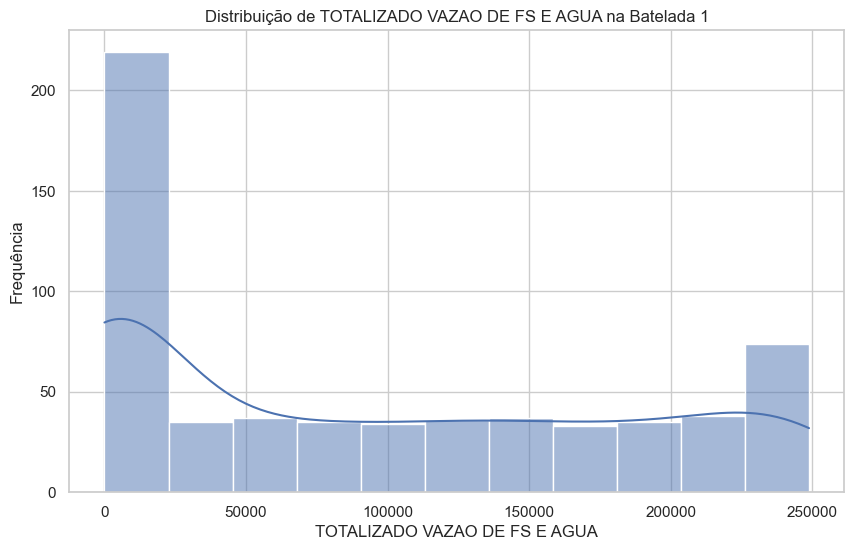

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


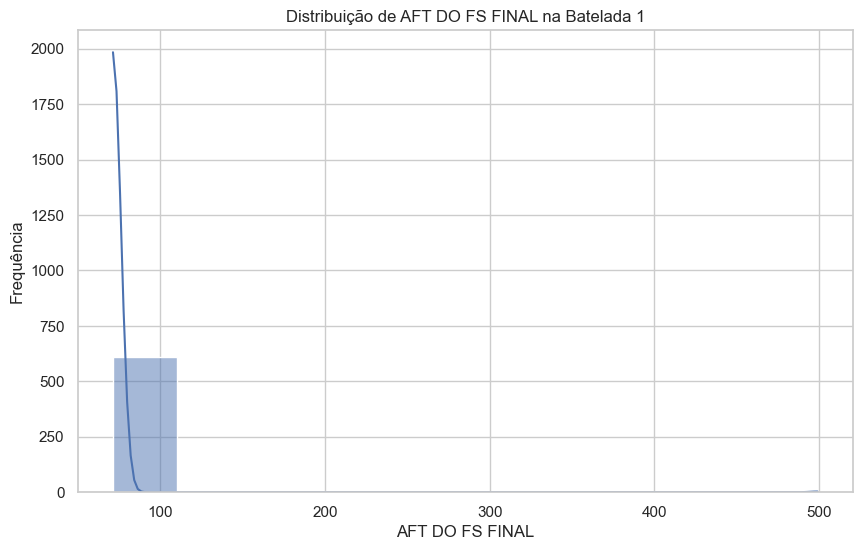

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


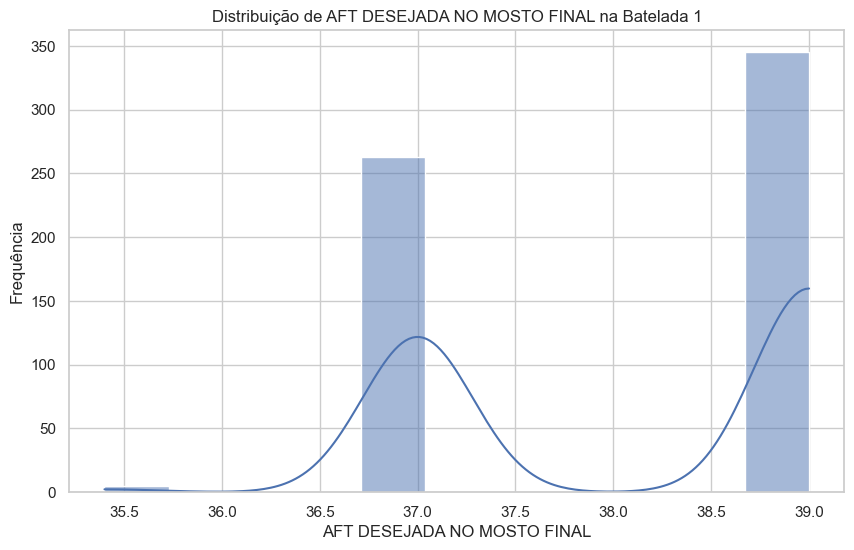

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


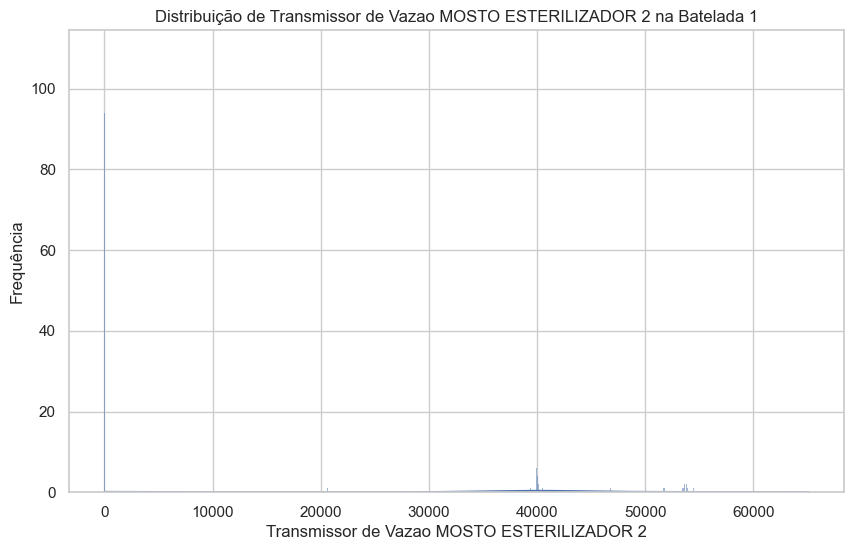

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar os dados da batelada 1
df_batelada1 = df

# Definir o estilo dos gráficos
sns.set(style="whitegrid")

# Plotar histogramas para cada coluna numérica
for column in df_batelada1.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_batelada1[column], kde=True)
    plt.title(f'Distribuição de {column} na Batelada 1')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()


## 1.1 Histograma Q-Qplot/ Testes de Normalidade

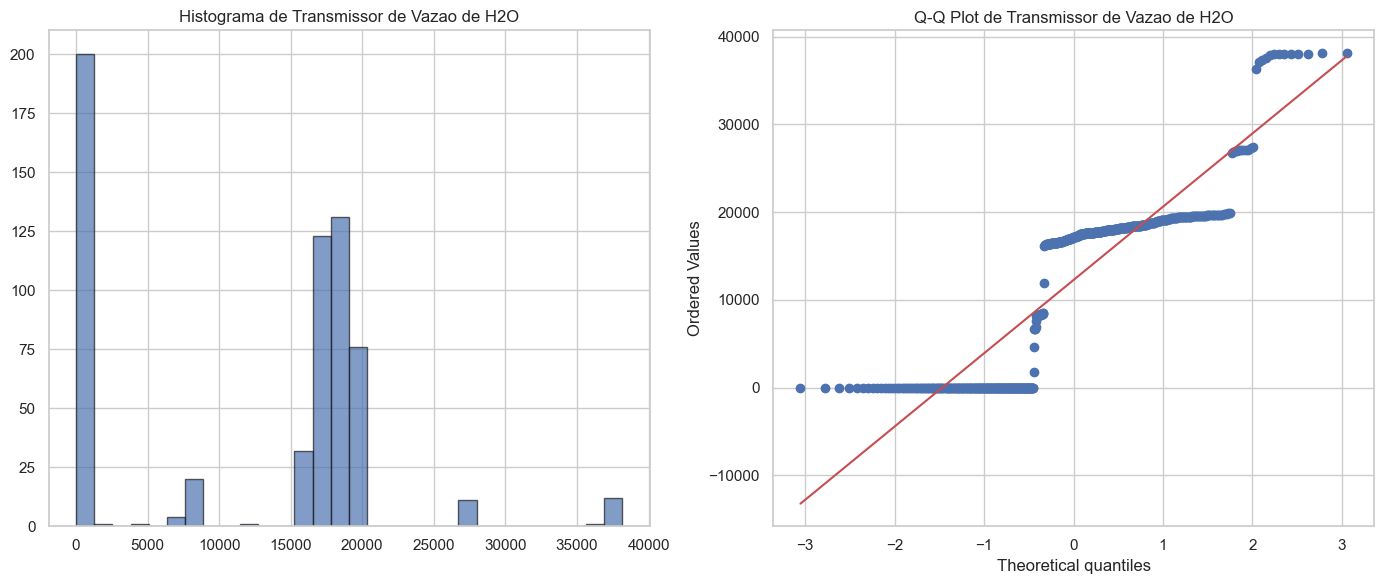


Testes de Normalidade para a coluna: Transmissor de Vazao de H2O
Shapiro-Wilk Test: Estatística=0.7834, p-valor=0.0000
Anderson-Darling Test: Estatística=62.9722, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.2929, p-valor=0.0000


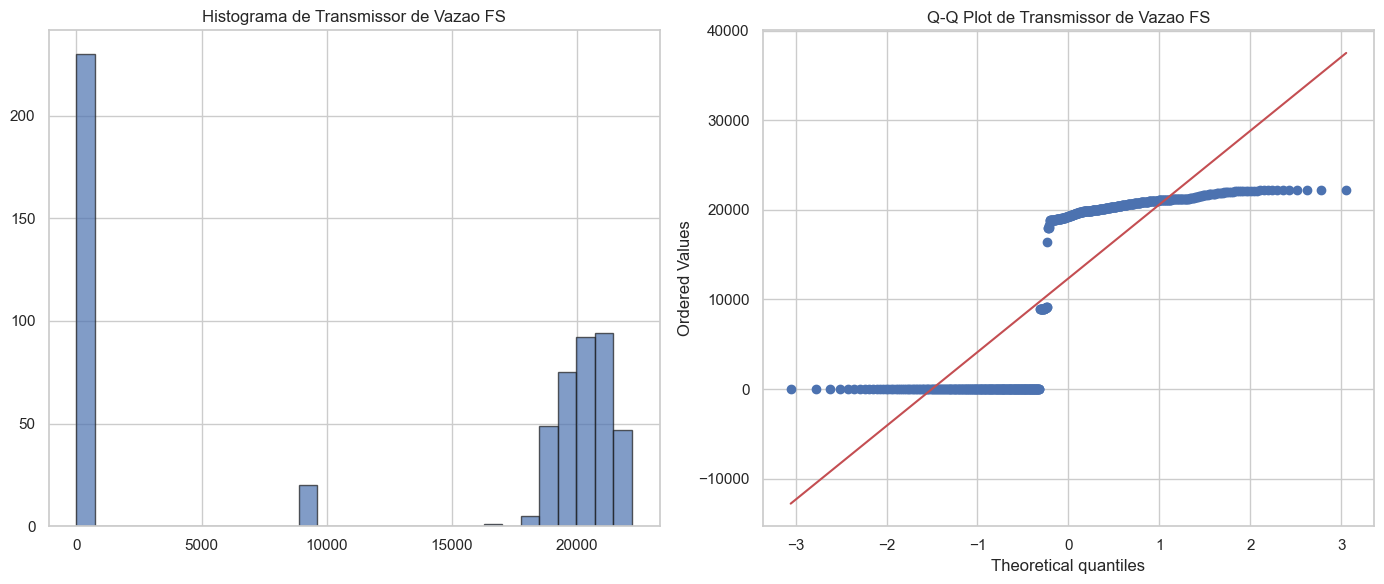


Testes de Normalidade para a coluna: Transmissor de Vazao FS
Shapiro-Wilk Test: Estatística=0.6952, p-valor=0.0000
Anderson-Darling Test: Estatística=88.1335, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.3255, p-valor=0.0000


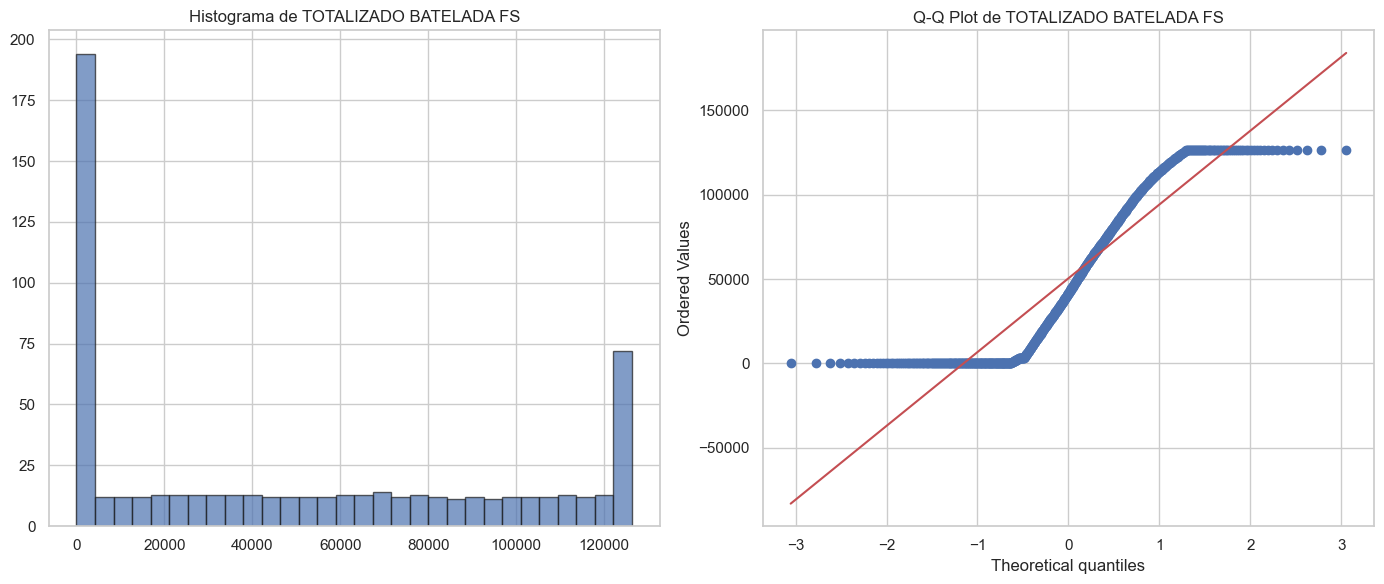


Testes de Normalidade para a coluna: TOTALIZADO BATELADA FS
Shapiro-Wilk Test: Estatística=0.8587, p-valor=0.0000
Anderson-Darling Test: Estatística=28.7569, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.1552, p-valor=0.0000


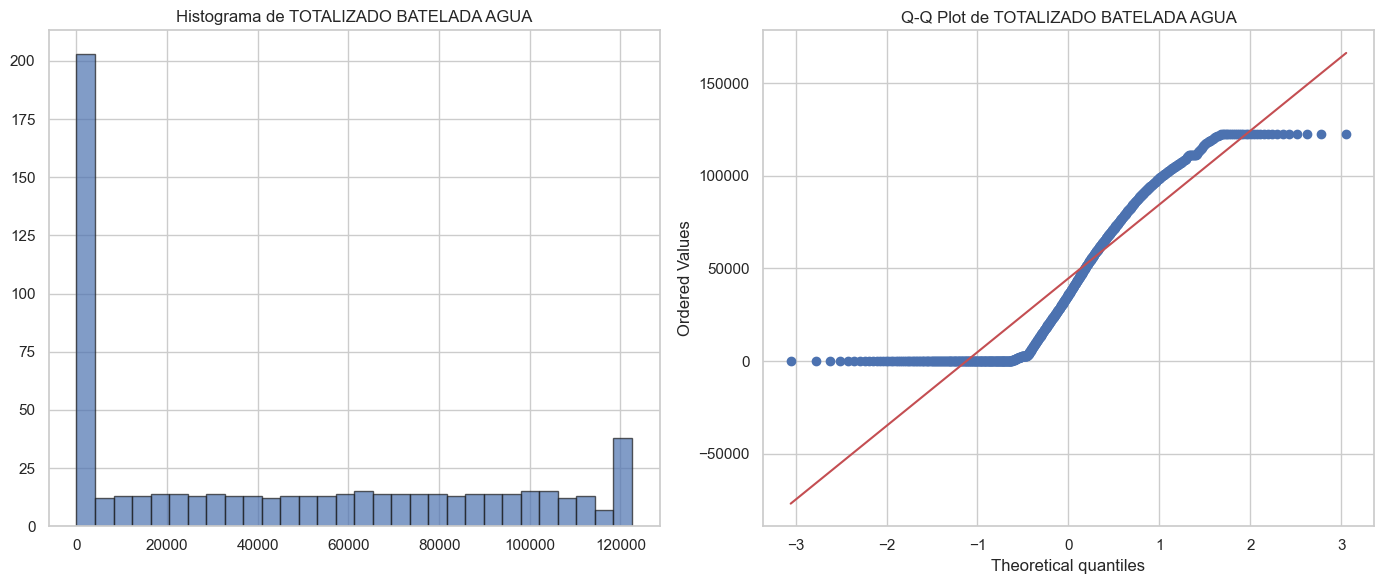


Testes de Normalidade para a coluna: TOTALIZADO BATELADA AGUA
Shapiro-Wilk Test: Estatística=0.8670, p-valor=0.0000
Anderson-Darling Test: Estatística=27.7074, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.1621, p-valor=0.0000


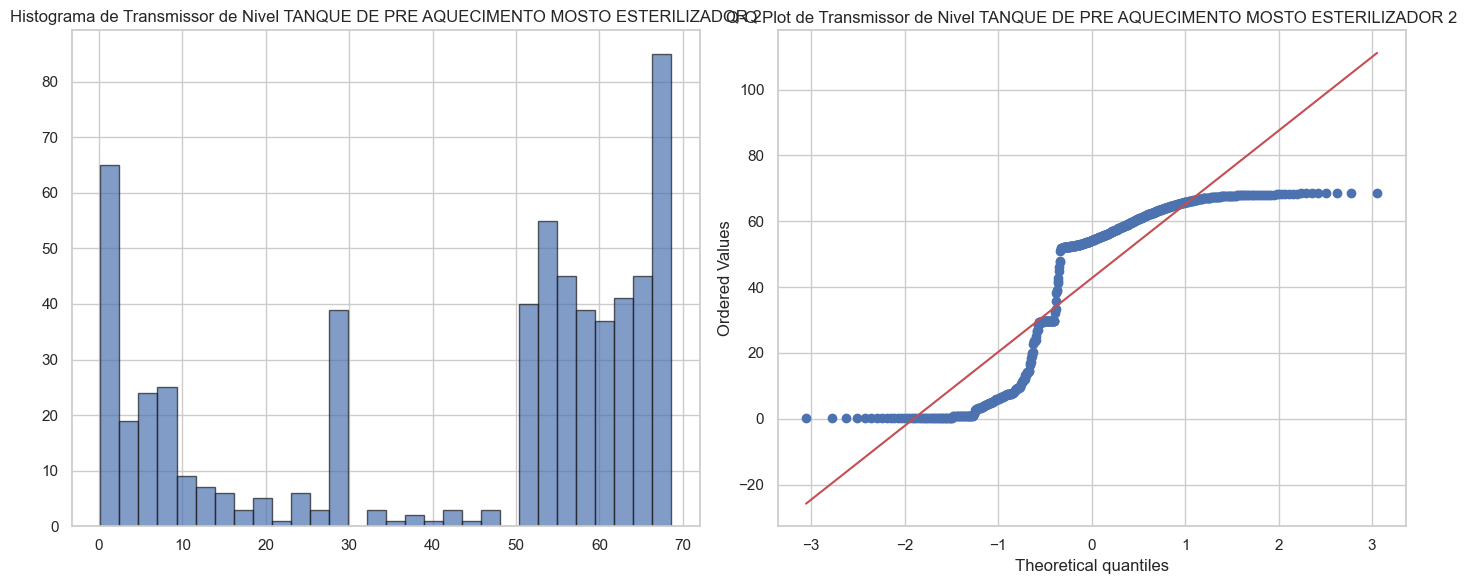


Testes de Normalidade para a coluna: Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2
Shapiro-Wilk Test: Estatística=0.8105, p-valor=0.0000
Anderson-Darling Test: Estatística=47.4069, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.2746, p-valor=0.0000


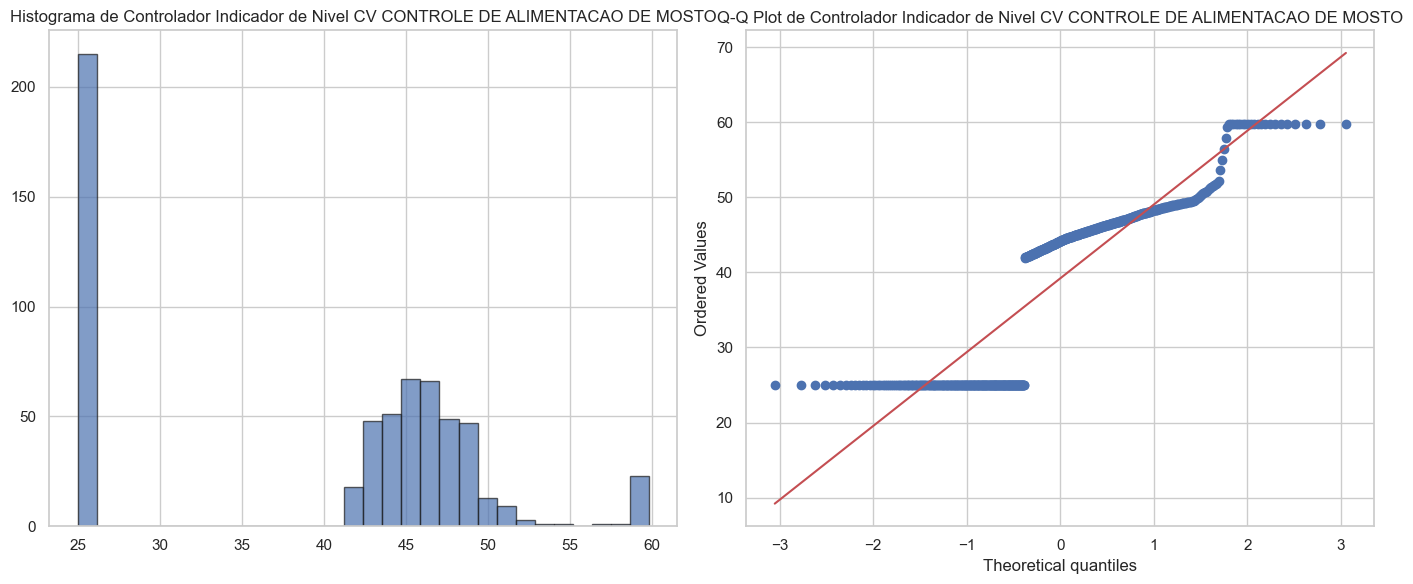


Testes de Normalidade para a coluna: Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO
Shapiro-Wilk Test: Estatística=0.7986, p-valor=0.0000
Anderson-Darling Test: Estatística=58.5980, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.2537, p-valor=0.0000


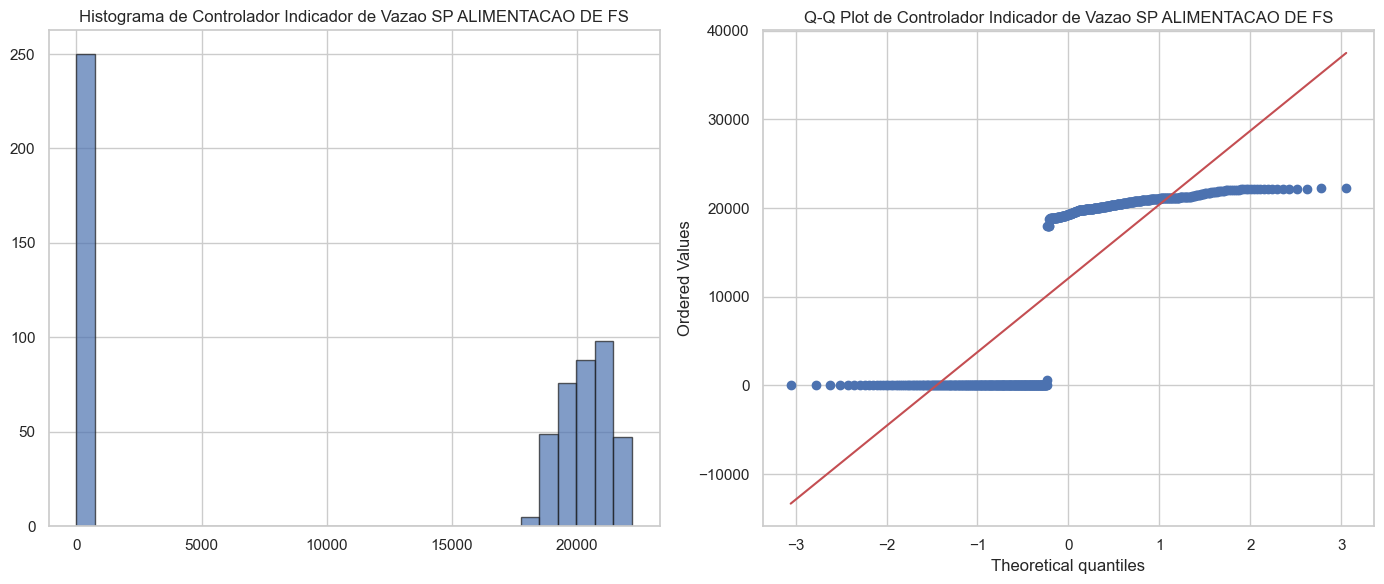


Testes de Normalidade para a coluna: Controlador Indicador de Vazao SP ALIMENTACAO DE FS
Shapiro-Wilk Test: Estatística=0.6769, p-valor=0.0000
Anderson-Darling Test: Estatística=95.8116, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.3306, p-valor=0.0000


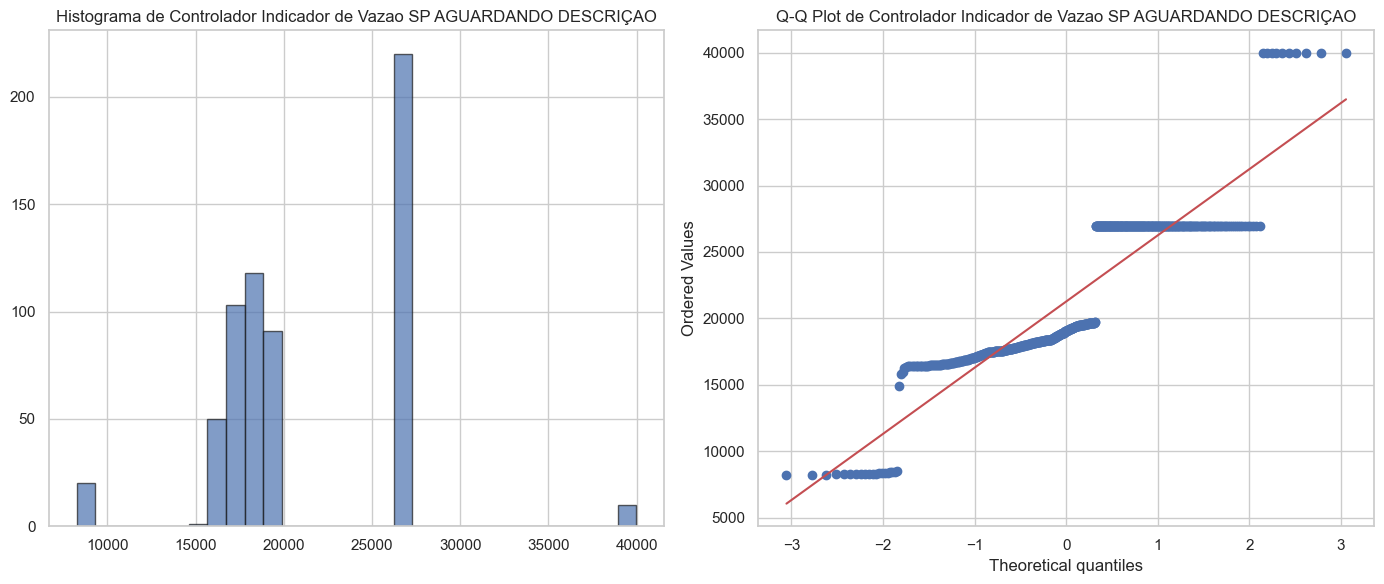


Testes de Normalidade para a coluna: Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO
Shapiro-Wilk Test: Estatística=0.8268, p-valor=0.0000
Anderson-Darling Test: Estatística=46.5864, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.2373, p-valor=0.0000


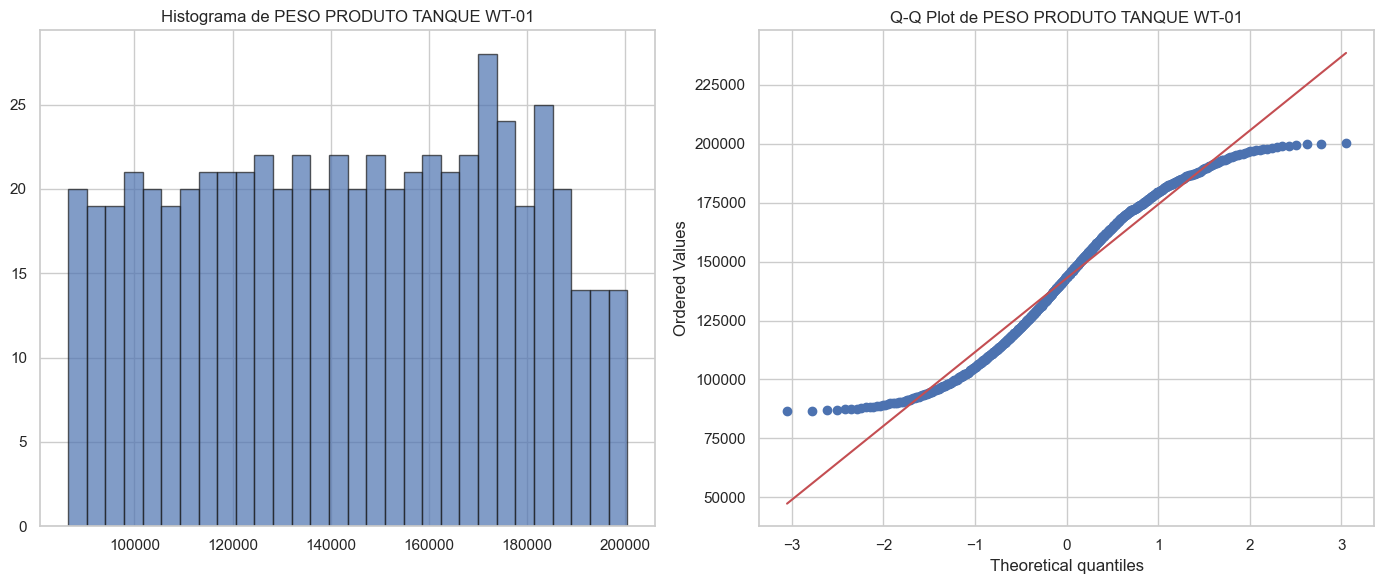


Testes de Normalidade para a coluna: PESO PRODUTO TANQUE WT-01
Shapiro-Wilk Test: Estatística=0.9593, p-valor=0.0000
Anderson-Darling Test: Estatística=6.2843, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.0655, p-valor=0.0100


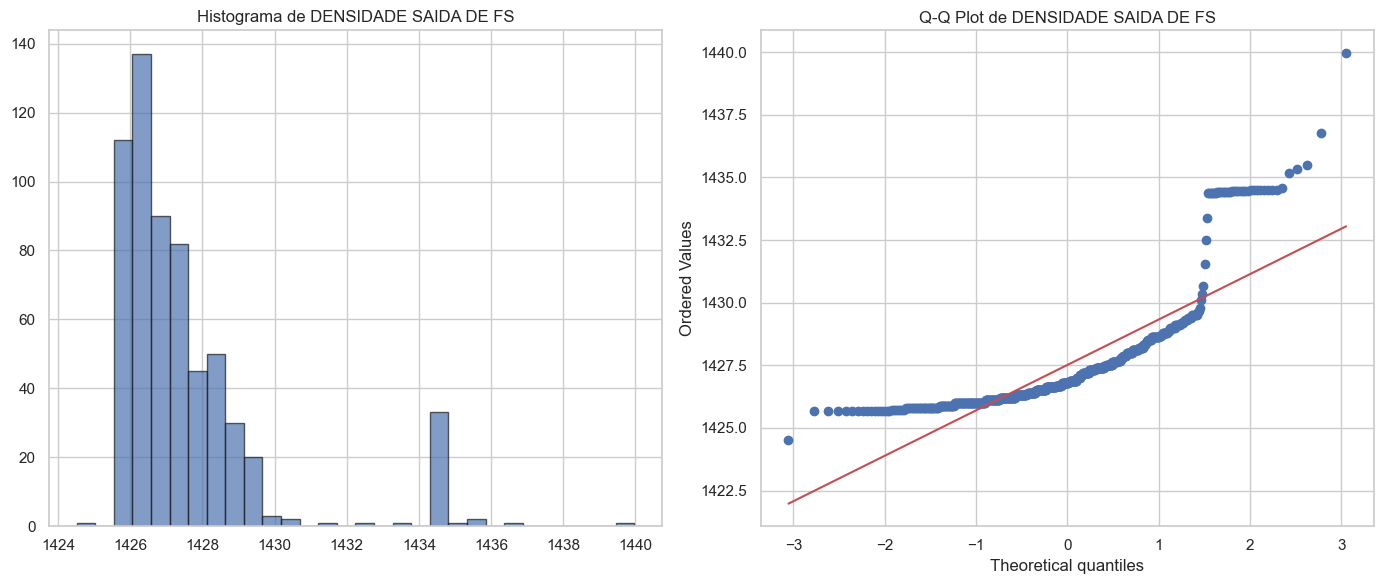


Testes de Normalidade para a coluna: DENSIDADE SAIDA DE FS
Shapiro-Wilk Test: Estatística=0.6984, p-valor=0.0000
Anderson-Darling Test: Estatística=55.1521, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.1979, p-valor=0.0000


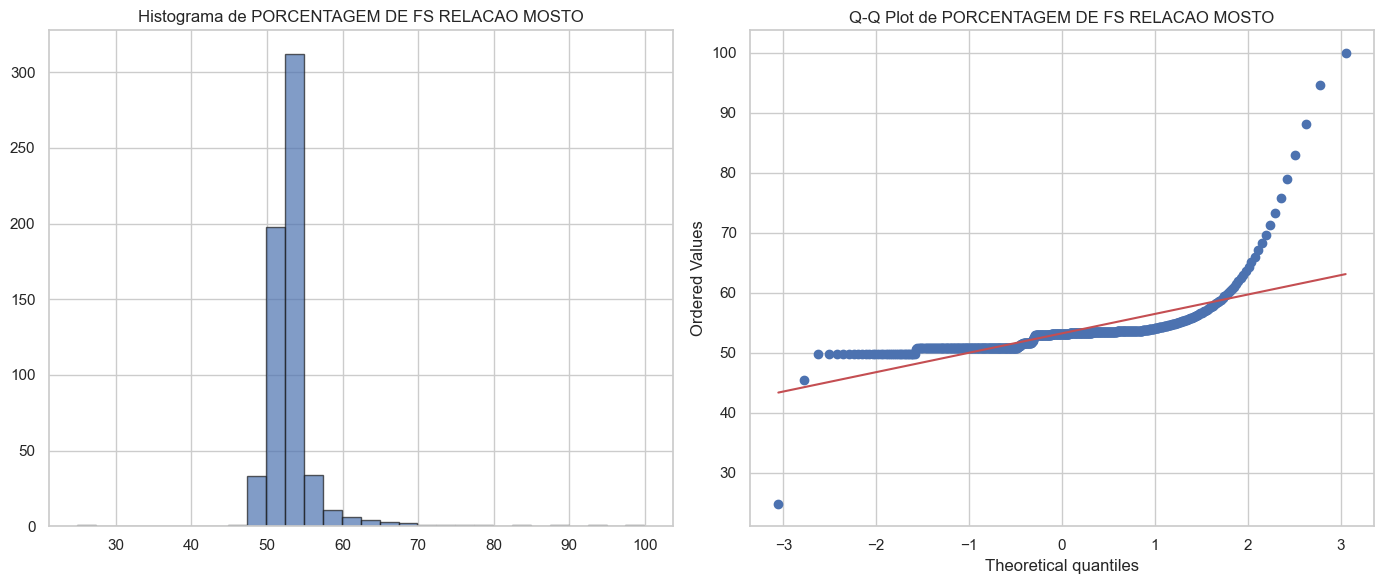


Testes de Normalidade para a coluna: PORCENTAGEM DE FS RELACAO MOSTO
Shapiro-Wilk Test: Estatística=0.5100, p-valor=0.0000
Anderson-Darling Test: Estatística=73.6487, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.2706, p-valor=0.0000


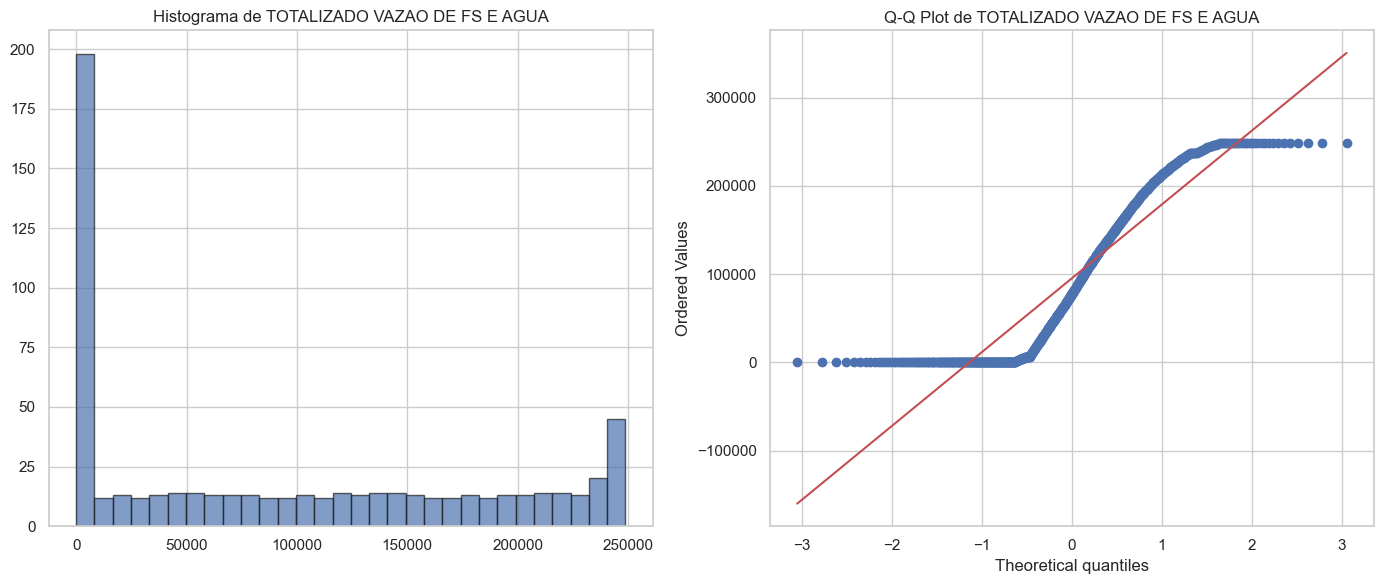


Testes de Normalidade para a coluna: TOTALIZADO VAZAO DE FS E AGUA
Shapiro-Wilk Test: Estatística=0.8635, p-valor=0.0000
Anderson-Darling Test: Estatística=28.1434, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.1588, p-valor=0.0000


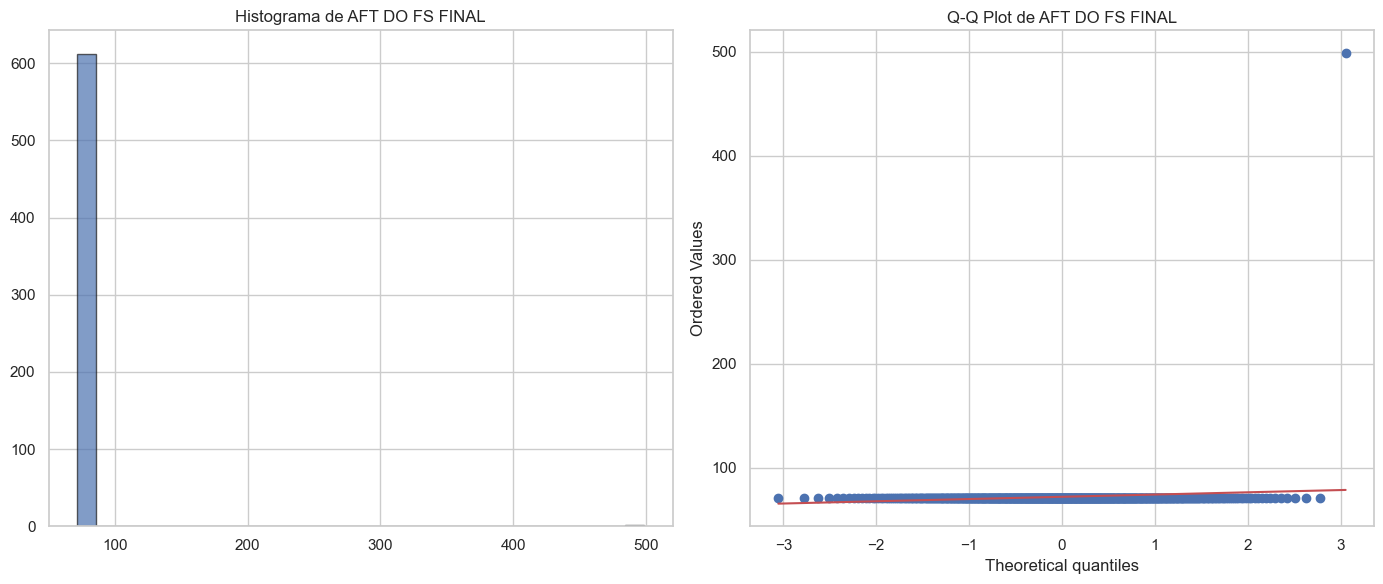


Testes de Normalidade para a coluna: AFT DO FS FINAL
Shapiro-Wilk Test: Estatística=0.0180, p-valor=0.0000
Anderson-Darling Test: Estatística=236.2447, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.5144, p-valor=0.0000


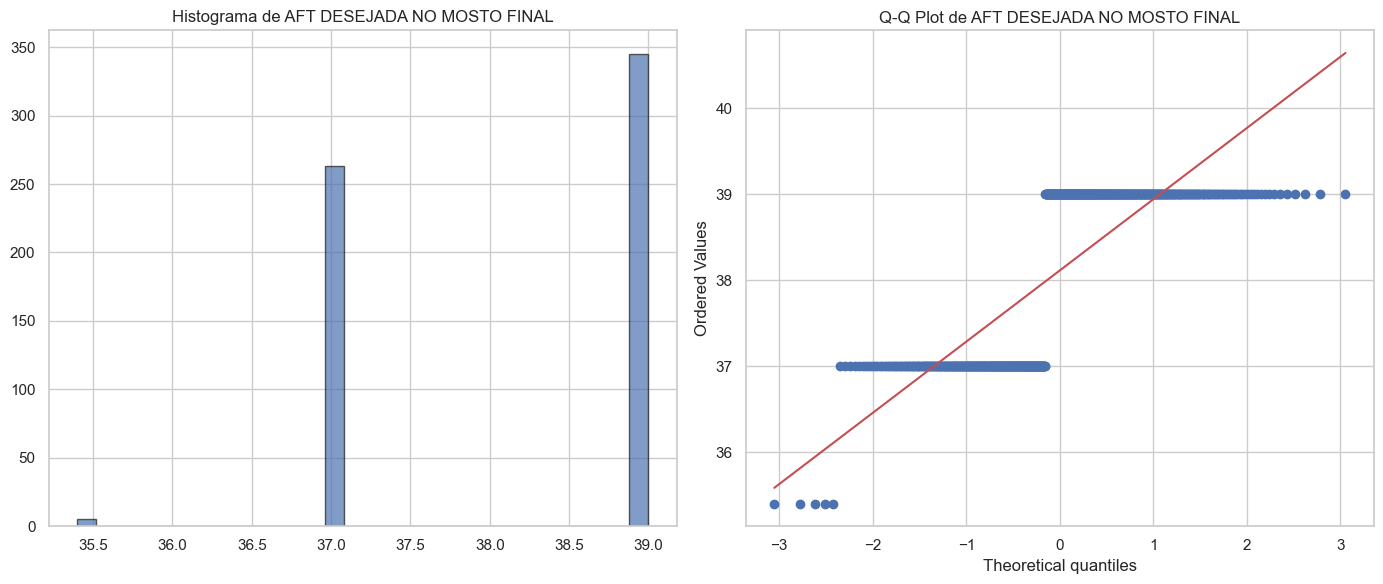


Testes de Normalidade para a coluna: AFT DESEJADA NO MOSTO FINAL
Shapiro-Wilk Test: Estatística=0.6560, p-valor=0.0000
Anderson-Darling Test: Estatística=106.5420, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.3712, p-valor=0.0000


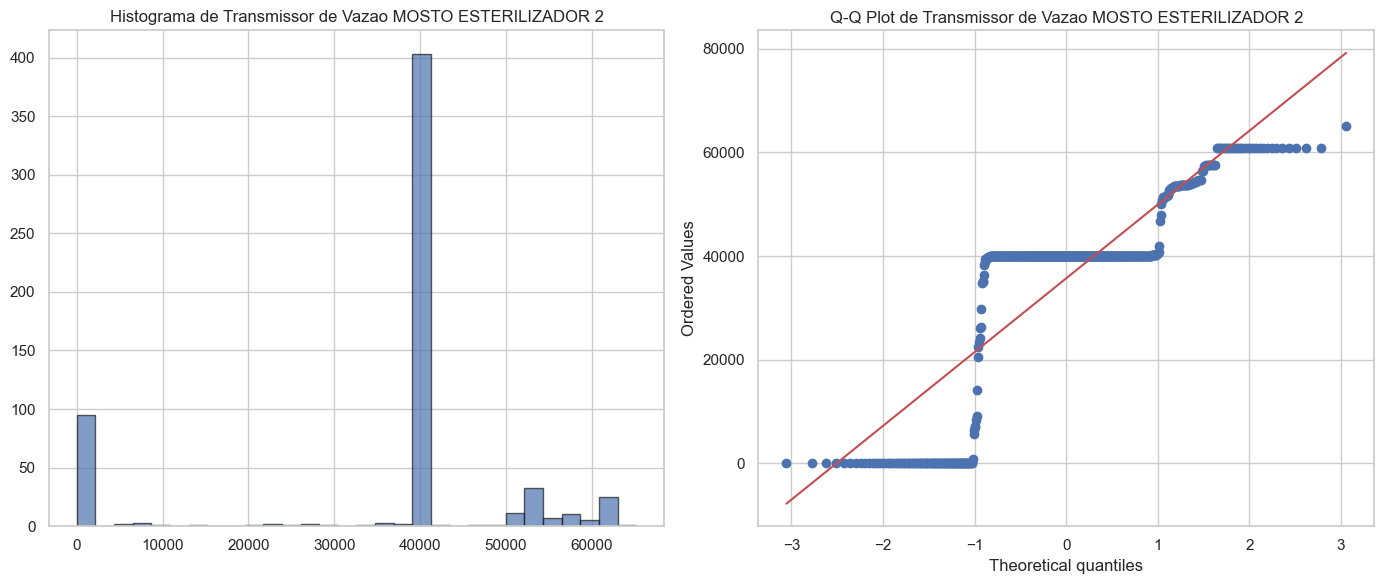


Testes de Normalidade para a coluna: Transmissor de Vazao MOSTO ESTERILIZADOR 2
Shapiro-Wilk Test: Estatística=0.7003, p-valor=0.0000
Anderson-Darling Test: Estatística=93.0758, Críticos=[0.572 0.652 0.782 0.912 1.085]
Kolmogorov-Smirnov Test: Estatística=0.3996, p-valor=0.0000


In [18]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Supondo que df_batelada1 seja o seu DataFrame
def plot_normality_tests(df, column):
    data = df[column].dropna()
    
    # Histograma
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma de {column}')
    
    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {column}')
    
    plt.tight_layout()
    plt.show()

def testar_normalidade(df, column):
    data = df[column].dropna()
    
    print(f'\nTestes de Normalidade para a coluna: {column}')
    
    # Shapiro-Wilk Test
    stat, p = stats.shapiro(data)
    print(f'Shapiro-Wilk Test: Estatística={stat:.4f}, p-valor={p:.4f}')
    
    # Anderson-Darling Test
    result = stats.anderson(data, dist='norm')
    print(f'Anderson-Darling Test: Estatística={result.statistic:.4f}, Críticos={result.critical_values}')
    
    # Kolmogorov-Smirnov Test (comparando com distribuição normal padrão)
    mu, std = data.mean(), data.std()
    stat, p = stats.kstest(data, 'norm', args=(mu, std))
    print(f'Kolmogorov-Smirnov Test: Estatística={stat:.4f}, p-valor={p:.4f}')

# Lista de colunas numéricas, excluindo "VAZAO DE MOSTO CALCULADA"
numerical_columns = [col for col in df_batelada1.select_dtypes(include=['float64', 'int64']).columns if col != 'VAZAO DE MOSTO CALCULADA']

for column in numerical_columns:
    plot_normality_tests(df_batelada1, column)
    testar_normalidade(df_batelada1, column)


In [19]:
## todos nossos dados não seguem a normalidade, dessa forma nao podemos executar testes de medida central

In [20]:

# Remova a coluna 'TimeStamp' antes de calcular a correlação
df_batelada1_sem_timestamp = df_batelada1.drop(columns=['TimeStamp'])

# Calcule a correlação de Spearman
correlacao_spearman = df_batelada1_sem_timestamp.corr(method='spearman')




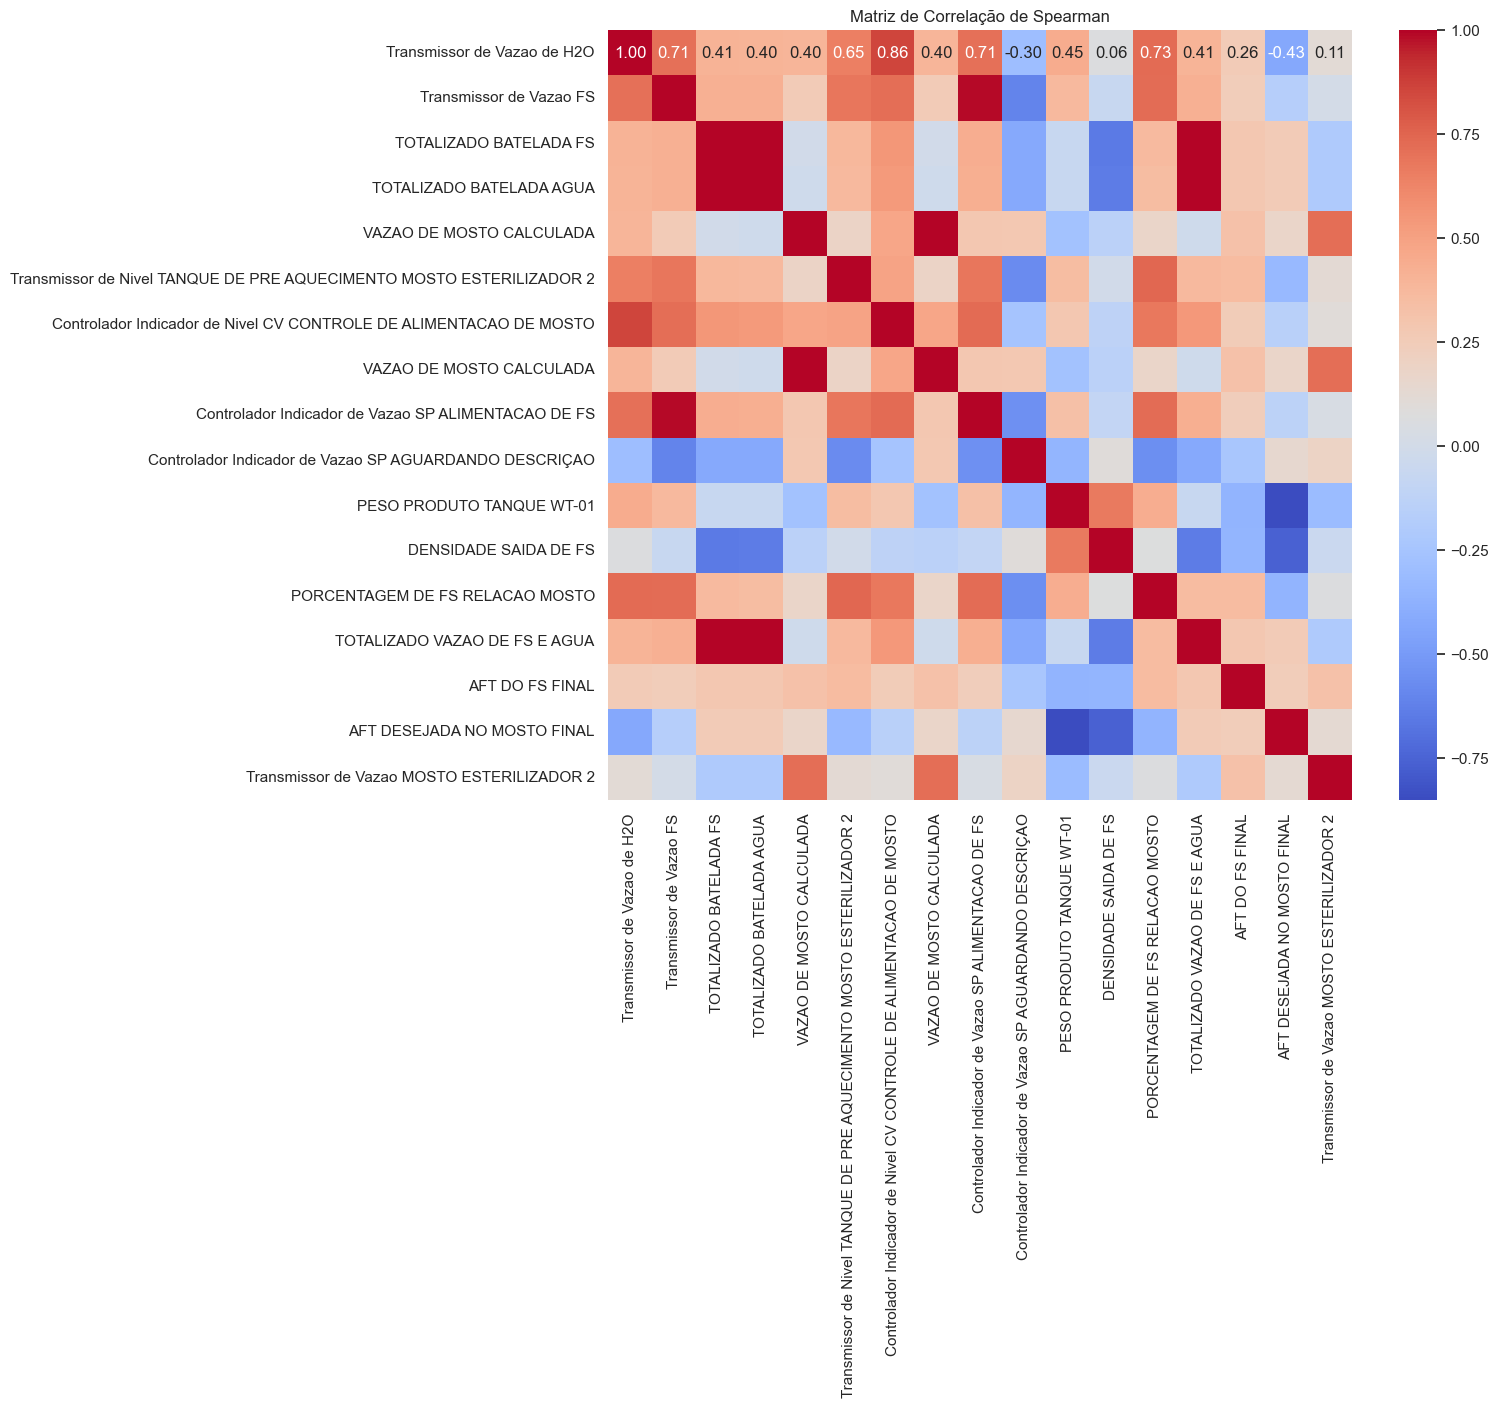

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlacao_spearman, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação de Spearman')
plt.show()

#### Correlações Fortes
     Transmissor de Vazao de H2O e VAZAO DE MOSTO CALCULADA: 0.811726
     Transmissor de Vazao FS e Controlador Indicador de Vazao SP ALIMENTACAO DE FS: 0.988404
     Totalizador de Vazao FT110003 - TOTALIZADO e TOTALIZADO BATELADA AGUA: 0.942056
     Totalizador de Vazao FT110003 - TOTALIZADO e TOTALIZADO BATELADA FS: 0.938883
     VAZAO DE MOSTO CALCULADA e Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO: 0.913938
#### Observações
     As variáveis Transmissor de Vazao de H2O e VAZAO DE MOSTO CALCULADA têm uma correlação muito forte, indicando que mudanças em uma tendem a estar associadas com mudanças na outra.
     As variáveis relacionadas aos totalizadores mostram correlações fortes entre si, sugerindo que elas estão fortemente ligadas no processo de esterilização.

#### Correlações Intermediárias
    Totalizador de Vazao FT110003 - TOTALIZADO e PORCENTAGEM DE FS RELACAO MOSTO: 0.542673
    Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO e Transmissor de Nivel TANQUE DE PRE-AQUECIMENTO MOSTO ESTERILIZADOR 2: 0.661411
    Controlador Indicador de Vazao SP ALIMENTACAO DE FS e PORCENTAGEM DE FS RELACAO MOSTO: 0.618733
    TOTALIZADO BATELADA FS e TOTALIZADO BATELADA AGUA: 0.692802
    PORCENTAGEM DE FS RELACAO MOSTO e TOTALIZADO BATELADA AGUA: 0.480510
    TOTALIZADO VAZAO DE FS E AGUA e TOTALIZADO BATELADA AGUA: 0.679857
    TOTALIZADO VAZAO DE FS E AGUA e TOTALIZADO BATELADA FS: 0.667107
#### Observações
    A variável PORCENTAGEM DE FS RELACAO MOSTO mostra correlações intermediárias com várias outras variáveis, sugerindo que essa porcentagem está moderadamente associada a outras medições no processo.
    A relação entre Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO e Transmissor de Nivel TANQUE DE PRE-AQUECIMENTO MOSTO ESTERILIZADOR 2 é moderadamente forte, o que pode indicar uma dependência mútua entre esses controles no processo.

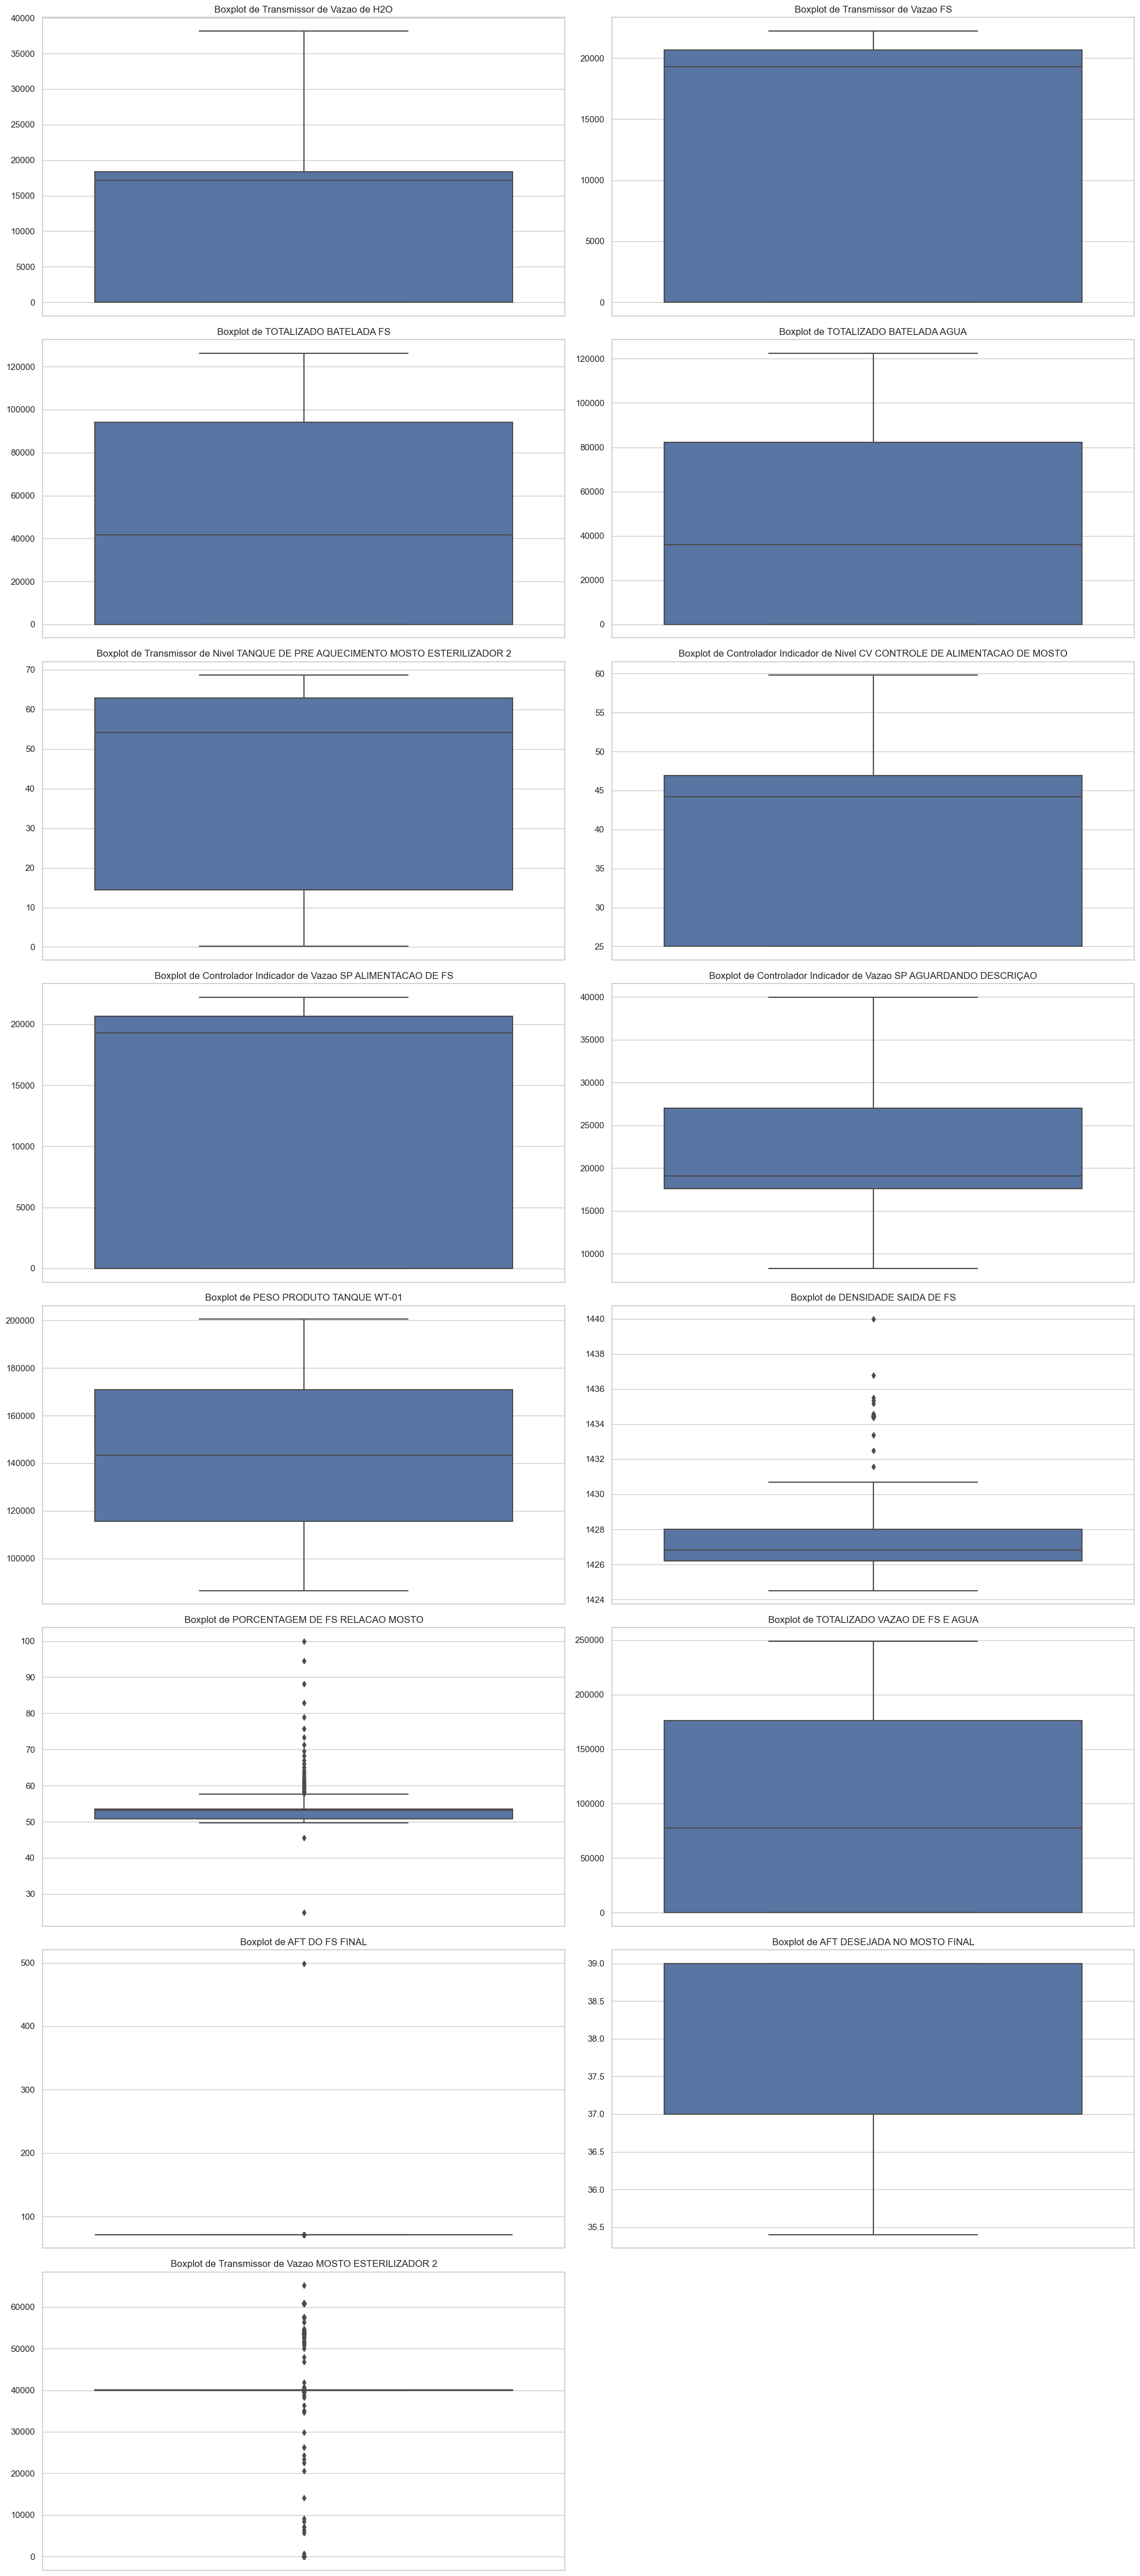

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Listar as colunas do DataFrame
colunas = df_batelada1.columns

# Filtrar apenas as colunas numéricas
colunas_numericas = [col for col in colunas if pd.api.types.is_numeric_dtype(df_batelada1[col])]

# Criar subplots para os boxplots
plt.figure(figsize=(20, len(colunas_numericas) * 3))  # Ajuste o tamanho da figura conforme necessário

for i, coluna in enumerate(colunas_numericas, 1):
    plt.subplot(len(colunas_numericas) // 2 + 1, 2, i)  # Ajuste o número de linhas e colunas
    sns.boxplot(data=df_batelada1, y=coluna)
    plt.title(f'Boxplot de {coluna}')
    plt.ylabel('')

plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Remover índices duplicados, se existirem
df_batelada1 = df_batelada1.loc[~df_batelada1.index.duplicated(keep='first')]

# Criar um DataFrame vazio para armazenar os resultados
outliers_df = pd.DataFrame(columns=['Coluna', 'Número de Outliers', 'Outliers'])

# Listar as colunas numéricas
colunas = [
    'Transmissor de Vazao de H2O',
    'Transmissor de Vazao FS',
    'TOTALIZADO BATELADA FS',
    'TOTALIZADO BATELADA AGUA',
    'VAZAO DE MOSTO CALCULADA',
    'Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2',
    'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO',
    'Controlador Indicador de Vazao SP ALIMENTACAO DE FS',
    'Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO',
    'Totalizador de Vazao FT110003 - TOTALIZADO',
    'PESO PRODUTO TANQUE WT-01',
    'DENSIDADE SAIDA DE FS',
    'PORCENTAGEM DE FS RELACAO MOSTO',
    'TOTALIZADO VAZAO DE FS E AGUA'
]

# Calcular os limites e detectar os outliers
resultados = []
for coluna in colunas:
    if coluna in df_batelada1.columns and pd.api.types.is_numeric_dtype(df_batelada1[coluna]):
        # Cálculo dos quartis e limites
        Q1 = df_batelada1[coluna].quantile(0.25)
        Q3 = df_batelada1[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Identificar os outliers
        outliers = df_batelada1[(df_batelada1[coluna] < limite_inferior) | (df_batelada1[coluna] > limite_superior)]
        
        # Armazenar resultados
        resultados.append({
            'Coluna': coluna,
            'Número de Outliers': len(outliers),
            'Outliers': outliers[coluna].tolist()
        })

# Criar o DataFrame com os resultados
outliers_df = pd.concat([outliers_df, pd.DataFrame(resultados)], ignore_index=True)



In [24]:
outliers_df

Coluna Número de Outliers  \
0                         Transmissor de Vazao de H2O                  0   
1                             Transmissor de Vazao FS                  0   
2                              TOTALIZADO BATELADA FS                  0   
3                            TOTALIZADO BATELADA AGUA                  0   
4   Transmissor de Nivel TANQUE DE PRE AQUECIMENTO...                  0   
5   Controlador Indicador de Nivel CV CONTROLE DE ...                  0   
6   Controlador Indicador de Vazao SP ALIMENTACAO ...                  0   
7   Controlador Indicador de Vazao SP AGUARDANDO D...                  0   
8                           PESO PRODUTO TANQUE WT-01                  0   
9                               DENSIDADE SAIDA DE FS                 41   
10                    PORCENTAGEM DE FS RELACAO MOSTO                 34   
11                      TOTALIZADO VAZAO DE FS E AGUA                  0   

                                             Outliers  
0                                                  []  
1                                                  []  
2                                                  []  
3                                                  []  
4                                                  []  
5                                                  []  
6                                                  []  
7                                                  []  
8                                                  []  
9   [1434.41, 1434.5, 1434.45, 1434.38, 1434.38, 1...  
10  [24.86, 45.52, 99.93, 94.52, 88.17, 83.0, 78.9...  
11                                                 []

In [25]:
from sklearn.ensemble import IsolationForest

# Selecionar colunas numéricas
colunas_numericas = df_batelada1.select_dtypes(include=['float64', 'int64']).columns

# Inicializar o modelo Isolation Forest
model = IsolationForest(contamination=0.05)  # Ajuste a contaminação conforme necessário

# Aplicar o modelo e detectar outliers
for coluna in colunas_numericas:
    dados = df_batelada1[[coluna]].dropna()
    if not dados.empty:
        model.fit(dados)
        predicoes = model.predict(dados)
        outliers = dados[predicoes == -1]
        num_outliers = len(outliers)
        print(f'Coluna: {coluna}')
        print(f'Número de Outliers: {num_outliers}')
        print(f'Outliers:\n{outliers.head()}')
        print()

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Transmissor de Vazao de H2O
Número de Outliers: 31
Outliers:
     Transmissor de Vazao de H2O
32                       4598.75
33                       7659.38
63                      11908.75
426                     36270.25
427                     37314.25



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Transmissor de Vazao FS
Número de Outliers: 31
Outliers:
    Transmissor de Vazao FS
33                  9053.50
34                  9154.00
35                  9098.88
36                  9072.00
37                  9022.12



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: TOTALIZADO BATELADA FS
Número de Outliers: 31
Outliers:
    TOTALIZADO BATELADA FS
67                 4452.29
68                 4800.88
69                 5166.57
70                 5514.06
71                 5867.11



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: TOTALIZADO BATELADA AGUA
Número de Outliers: 31
Outliers:
    TOTALIZADO BATELADA AGUA
36                    529.30
75                   4035.50
76                   4362.46
77                   4700.20
78                   5022.71



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: VAZAO DE MOSTO CALCULADA
Número de Outliers: 31
Outliers:
    VAZAO DE MOSTO CALCULADA  VAZAO DE MOSTO CALCULADA
53                  15314.06                  15314.06
54                  27323.44                  27323.44
55                  30635.16                  30635.16
56                  30478.12                  30478.12
57                  30175.78                  30175.78



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2
Número de Outliers: 31
Outliers:
    Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2
38                                              13.94                   
39                                              17.23                   
40                                              20.42                   
41                                              23.48                   
42                                              26.53                   



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO
Número de Outliers: 31
Outliers:
     Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO
63                                               51.91                 
64                                               51.77                 
65                                               51.62                 
433                                              52.14                 
434                                              53.58                 



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: VAZAO DE MOSTO CALCULADA
Número de Outliers: 31
Outliers:
    VAZAO DE MOSTO CALCULADA  VAZAO DE MOSTO CALCULADA
53                  15314.06                  15314.06
54                  27323.44                  27323.44
55                  30635.16                  30635.16
56                  30478.12                  30478.12
57                  30175.78                  30175.78



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Controlador Indicador de Vazao SP ALIMENTACAO DE FS
Número de Outliers: 31
Outliers:
     Controlador Indicador de Vazao SP ALIMENTACAO DE FS
52                                              658.99  
63                                            18752.29  
261                                           18797.88  
262                                           18798.50  
263                                           18025.25  



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO
Número de Outliers: 30
Outliers:
    Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO
33                                            8394.12     
34                                            8488.25     
35                                            8433.38     
36                                            8410.25     
37                                            8374.12     



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: PESO PRODUTO TANQUE WT-01
Número de Outliers: 31
Outliers:
   PESO PRODUTO TANQUE WT-01
0                   200467.0
1                   200110.0
2                   199932.0
3                   199457.0
4                   199160.0



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: DENSIDADE SAIDA DE FS
Número de Outliers: 24
Outliers:
    DENSIDADE SAIDA DE FS
0                 1434.41
3                 1434.38
4                 1434.38
18                1434.38
19                1434.38



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: PORCENTAGEM DE FS RELACAO MOSTO
Número de Outliers: 31
Outliers:
    PORCENTAGEM DE FS RELACAO MOSTO
32                            24.86
33                            45.52
62                            99.93
63                            94.52
64                            88.17



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: TOTALIZADO VAZAO DE FS E AGUA
Número de Outliers: 31
Outliers:
    TOTALIZADO VAZAO DE FS E AGUA
37                        1370.37
38                        1655.49
39                        1943.97
73                        9947.41
74                       10627.84



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: AFT DO FS FINAL
Número de Outliers: 31
Outliers:
   AFT DO FS FINAL
0            71.21
1            71.21
2            71.21
3            71.21
4            71.21



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: AFT DESEJADA NO MOSTO FINAL
Número de Outliers: 5
Outliers:
     AFT DESEJADA NO MOSTO FINAL
263                         35.4
264                         35.4
265                         35.4
266                         35.4
267                         35.4

Coluna: Transmissor de Vazao MOSTO ESTERILIZADOR 2
Número de Outliers: 31
Outliers:
     Transmissor de Vazao MOSTO ESTERILIZADOR 2
53                                     20628.12
54                                     36281.25
63                                     34999.71
435                                    38891.76
446                                    34739.06



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [26]:
df_batelada1.describe()

TimeStamp  Transmissor de Vazao de H2O  \
count                            613                   613.000000   
mean   2024-08-01 14:14:59.999999744                 12281.314176   
min              2024-08-01 09:09:00                     0.000000   
25%              2024-08-01 11:42:00                     0.000000   
50%              2024-08-01 14:15:00                 17160.000000   
75%              2024-08-01 16:48:00                 18396.750000   
max              2024-08-01 19:21:00                 38153.120000   
std                              NaN                  9391.468452   

       Transmissor de Vazao FS  TOTALIZADO BATELADA FS  \
count               613.000000              613.000000   
mean              12365.409494            50478.899576   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%               19290.120000            41673.970000   
75%               20640.250000            93983.020000   
max               22213.620000           126317.000000   
std                9826.297862            46973.239154   

       TOTALIZADO BATELADA AGUA  VAZAO DE MOSTO CALCULADA  \
count                613.000000                613.000000   
mean               44681.256232              32500.177781   
min                    0.000000                  0.000000   
25%                    0.000000              36343.280000   
50%                35931.420000              38275.000000   
75%                82304.160000              40345.330000   
max               122541.990000              46000.000000   
std                42590.193237              14779.539264   

       Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  \
count                                         613.000000                      
mean                                           42.678907                      
min                                             0.160000                      
25%                                            14.410000                      
50%                                            54.170000                      
75%                                            62.800000                      
max                                            68.630000                      
std                                            24.779912                      

       Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
count                                         613.000000                    
mean                                           39.210962                    
min                                            25.000000                    
25%                                            25.000000                    
50%                                            44.180000                    
75%                                            46.930000                    
max                                            59.790000                    
std                                            10.943426                    

       VAZAO DE MOSTO CALCULADA  \
count                613.000000   
mean               32500.177781   
min                    0.000000   
25%                36343.280000   
50%                38275.000000   
75%                40345.330000   
max                46000.000000   
std                14779.539264   

       Controlador Indicador de Vazao SP ALIMENTACAO DE FS  \
count                                         613.000000     
mean                                        12078.379592     
min                                             0.000000     
25%                                             0.000000     
50%                                         19287.120000     
75%                                         20647.500000     
max                                         22211.250000     
std                                         10056.572706     

       Controlador Indicador de Vazao SP AGUARDANDO

In [27]:
#from sklearn.ensemble import IsolationForest

# Selecionar colunas numéricas
#colunas_numericas = df_batelada1.select_dtypes(include=['float64', 'int64']).columns

# Inicializar o modelo Isolation Forest
#model = IsolationForest(contamination=0.05)  # Ajuste a contaminação conforme necessário

# Aplicar o modelo e detectar outliers
#for coluna in colunas_numericas:
 #   dados = df_batelada1[[coluna]].dropna()
  #  if not dados.empty:
   #     model.fit(dados)
    #    predicoes = model.predict(dados)
     #   outliers = dados[predicoes == -1]
      #  num_outliers = len(outliers)
       # print(f'Coluna: {coluna}')
        #print(f'Número de Outliers: {num_outliers}')
        #print(f'Outliers:\n{outliers.head()}')
        #print()

        # Remover outliers
        #df_batelada1 = df_batelada1[df_batelada1[coluna].isin(outliers[coluna]) == False]

## novo

from sklearn.ensemble import IsolationForest

# Selecionar colunas numéricas
colunas_numericas = df_batelada1.select_dtypes(include=['float64', 'int64']).columns

# Inicializar o modelo Isolation Forest
model = IsolationForest(contamination=0.05)  # Ajuste a contaminação conforme necessário

# Aplicar o modelo e detectar outliers
for coluna in colunas_numericas:
    dados = df_batelada1[[coluna]].dropna()
    if not dados.empty:
        model.fit(dados)
        predicoes = model.predict(dados)
        outliers = dados[predicoes == -1]
        num_outliers = len(outliers)
        print(f'Coluna: {coluna}')
        print(f'Número de Outliers: {num_outliers}')
        print(f'Outliers:\n{outliers.head()}')
        print()

        # Remover outliers
        df_batelada1 = df_batelada1[~df_batelada1.index.isin(outliers.index)]

print("Outliers removidos com sucesso!")


C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Transmissor de Vazao de H2O
Número de Outliers: 31
Outliers:
     Transmissor de Vazao de H2O
32                       4598.75
33                       7659.38
63                      11908.75
426                     36270.25
427                     37314.25



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Transmissor de Vazao FS
Número de Outliers: 30
Outliers:
    Transmissor de Vazao FS
34                  9154.00
35                  9098.88
36                  9072.00
37                  9022.12
38                  9129.75



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: TOTALIZADO BATELADA FS
Número de Outliers: 28
Outliers:
    TOTALIZADO BATELADA FS
65                 3740.02
66                 4098.51
67                 4452.29
68                 4800.88
69                 5166.57



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: TOTALIZADO BATELADA AGUA
Número de Outliers: 9
Outliers:
     TOTALIZADO BATELADA AGUA
407                 103830.28
408                 104098.12
429                 111132.60
430                 111132.60
431                 111132.60



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: VAZAO DE MOSTO CALCULADA
Número de Outliers: 26
Outliers:
    VAZAO DE MOSTO CALCULADA  VAZAO DE MOSTO CALCULADA
53                  15314.06                  15314.06
54                  27323.44                  27323.44
55                  30635.16                  30635.16
56                  30478.12                  30478.12
59                  29976.56                  29976.56



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2
Número de Outliers: 25
Outliers:
     Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2
487                                               1.42                   
490                                              12.16                   
491                                              11.29                   
492                                              10.46                   
493                                               9.52                   



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO
Número de Outliers: 23
Outliers:
    Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO
64                                              51.77                 
74                                              50.32                 
77                                              49.89                 
78                                              49.74                 
79                                              49.60                 



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: VAZAO DE MOSTO CALCULADA
Número de Outliers: 20
Outliers:
     VAZAO DE MOSTO CALCULADA  VAZAO DE MOSTO CALCULADA
57                   30175.78                  30175.78
58                   30220.31                  30220.31
60                   30004.69                  30004.69
62                   30145.31                  30145.31
509                  43155.47                  43155.47



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Controlador Indicador de Vazao SP ALIMENTACAO DE FS
Número de Outliers: 21
Outliers:
     Controlador Indicador de Vazao SP ALIMENTACAO DE FS
151                                           19089.12  
260                                           18839.00  
261                                           18797.88  
262                                           18798.50  
308                                           21590.25  



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO
Número de Outliers: 20
Outliers:
    Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO
81                                           19615.62     
82                                           19637.12     
83                                           19661.50     
84                                           19645.62     
85                                           19625.12     



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: PESO PRODUTO TANQUE WT-01
Número de Outliers: 19
Outliers:
   PESO PRODUTO TANQUE WT-01
0                   200467.0
1                   200110.0
2                   199932.0
3                   199457.0
4                   199160.0



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: DENSIDADE SAIDA DE FS
Número de Outliers: 16
Outliers:
    DENSIDADE SAIDA DE FS
9                 1434.50
10                1434.45
12                1434.50
13                1434.50
14                1434.50



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: PORCENTAGEM DE FS RELACAO MOSTO
Número de Outliers: 18
Outliers:
    PORCENTAGEM DE FS RELACAO MOSTO
8                             49.71
11                            49.71
20                            49.71
22                            49.71
24                            49.71



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: TOTALIZADO VAZAO DE FS E AGUA
Número de Outliers: 4
Outliers:
     TOTALIZADO VAZAO DE FS E AGUA
102                       29508.26
103                       30139.98
405                      222563.53
406                      223163.27



C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Coluna: AFT DO FS FINAL
Número de Outliers: 0
Outliers:
Empty DataFrame
Columns: [AFT DO FS FINAL]
Index: []

Coluna: AFT DESEJADA NO MOSTO FINAL
Número de Outliers: 0
Outliers:
Empty DataFrame
Columns: [AFT DESEJADA NO MOSTO FINAL]
Index: []

Coluna: Transmissor de Vazao MOSTO ESTERILIZADOR 2
Número de Outliers: 14
Outliers:
     Transmissor de Vazao MOSTO ESTERILIZADOR 2
499                                    47956.25
500                                    50753.12
512                                    60871.51
513                                    60795.50
515                                    60804.25

Outliers removidos com sucesso!


C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 18 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   TimeStamp                                                             613 non-null    datetime64[ns]
 1   Transmissor de Vazao de H2O                                           613 non-null    float64       
 2   Transmissor de Vazao FS                                               613 non-null    float64       
 3   TOTALIZADO BATELADA FS                                                613 non-null    float64       
 4   TOTALIZADO BATELADA AGUA                                              613 non-null    float64       
 5   VAZAO DE MOSTO CALCULADA                                              613 non-null    float64       
 6   Transmissor de Nivel TANQUE DE PRE AQUECIM

In [29]:
df.head()

TimeStamp  Transmissor de Vazao de H2O  Transmissor de Vazao FS  \
0 2024-08-01 09:09:00                          0.0                      0.0   
1 2024-08-01 09:10:00                          0.0                      0.0   
2 2024-08-01 09:11:00                          0.0                      0.0   
3 2024-08-01 09:12:00                          0.0                      0.0   
4 2024-08-01 09:13:00                          0.0                      0.0   

   TOTALIZADO BATELADA FS  TOTALIZADO BATELADA AGUA  VAZAO DE MOSTO CALCULADA  \
0                     0.0                       0.0                       0.0   
1                     0.0                       0.0                       0.0   
2                     0.0                       0.0                       0.0   
3                     0.0                       0.0                       0.0   
4                     0.0                       0.0                       0.0   

   Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  \
0                                               0.19                      
1                                               0.19                      
2                                               0.18                      
3                                               0.18                      
4                                               0.17                      

   Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
0                                               25.0                    
1                                               25.0                    
2                                               25.0                    
3                                               25.0                    
4                                               25.0                    

   VAZAO DE MOSTO CALCULADA  \
0                       0.0   
1                       0.0   
2                       0.0   
3                       0.0   
4                       0.0   

   Controlador Indicador de Vazao SP ALIMENTACAO DE FS  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO  \
0                                           26983.12        
1                                           26983.12        
2                                           26983.12        
3                                           26983.12        
4                                           26983.12        

   PESO PRODUTO TANQUE WT-01  DENSIDADE SAIDA DE FS  \
0                   200467.0                1434.41   
1                   200110.0                1434.50   
2                   199932.0                1434.45   
3                   199457.0                1434.38   
4                   199160.0                1434.38   

   PORCENTAGEM DE FS RELACAO MOSTO  TOTALIZADO VAZAO DE FS E AGUA  \
0                            49.71                            0.0   
1                            49.71                            0.0   
2                            49.71                            0.0   
3                            49.71                            0.0   
4                            49.71                            0.0   

   AFT DO FS FINAL  AFT DESEJADA NO MOSTO FINAL  \
0            71.21                         37.0   
1            71.21                         37.0   
2            71.21                         37.0   
3            71.21                         37.0   
4            71.21                         37.0   

   Transmissor de Vazao MOSTO ESTERILIZADOR 2  
0                                         0.0  
1                                         0.0  
2                                         0.0  
3           

In [30]:
df_batelada1["Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO"] = df_batelada1["Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO"] / 100

In [31]:
df_batelada1["AFT DESEJADA NO MOSTO FINAL"] = df_batelada1["AFT DESEJADA NO MOSTO FINAL"] / 100

In [32]:
df_batelada1["AFT DO FS FINAL"] = df_batelada1["AFT DO FS FINAL"] / 100

In [33]:
df_batelada1['Fator Vazão'] = ((df_batelada1['Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO'] - 0.6)*-1)

In [36]:
df_batelada1['Vazão de Mosto Desejada'] = df_batelada1['Fator Vazão'] * df_batelada1['Transmissor de Vazao MOSTO ESTERILIZADOR 2']

In [37]:
df_batelada1['valor do setpoint'] = df_batelada1['Transmissor de Vazao MOSTO ESTERILIZADOR 2'] + df_batelada1['Vazão de Mosto Desejada']

In [38]:
import pandas as pd

# Supondo que df_batelada1 já esteja carregado e filtrado

# Cálculos para df_batelada1
#df_batelada1['Fator Vazão'] = ((df_batelada1['Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO'] - 0.6)  )
#df_batelada1['Vazão de Mosto Desejada'] = df_batelada1['Fator Vazão'] * df_batelada1['Totalizador de Vazao FT110003 - TOTALIZADO']
#df_batelada1['valor do setpoint'] = df_batelada1['Totalizador de Vazao FT110003 - TOTALIZADO'] + df_batelada1['Vazão de Mosto Desejada']
df_batelada1['Vazão de FS'] = ((df_batelada1['AFT DESEJADA NO MOSTO FINAL']) / (df_batelada1['AFT DO FS FINAL'])) * df_batelada1['valor do setpoint']

df_batelada1['entrada de agua'] = (((df_batelada1['AFT DO FS FINAL']) - (df_batelada1['AFT DESEJADA NO MOSTO FINAL'])) / (df_batelada1['AFT DESEJADA NO MOSTO FINAL'])) * df_batelada1['Transmissor de Vazao de H2O']


In [39]:
pd.set_option('display.max_columns', 100)

In [40]:
df_batelada1.describe()

TimeStamp  Transmissor de Vazao de H2O  \
count                            309                   309.000000   
mean   2024-08-01 14:17:18.446601984                 13866.726893   
min              2024-08-01 10:53:00                     0.000000   
25%              2024-08-01 12:17:00                 16358.120000   
50%              2024-08-01 13:56:00                 17668.500000   
75%              2024-08-01 15:46:00                 18419.380000   
max              2024-08-01 19:13:00                 19735.120000   
std                              NaN                  7629.312934   

       Transmissor de Vazao FS  TOTALIZADO BATELADA FS  \
count               309.000000              309.000000   
mean              15624.624304            56987.246343   
min                   0.000000                0.000000   
25%               18888.380000            27114.010000   
50%               19863.500000            53851.720000   
75%               20791.880000            88445.070000   
max               22122.620000           126317.000000   
std                8582.804717            39633.371584   

       TOTALIZADO BATELADA AGUA  VAZAO DE MOSTO CALCULADA  \
count                309.000000                309.000000   
mean               50377.356731              34418.315987   
min                    0.000000                  0.000000   
25%                22442.650000              36488.050000   
50%                47217.360000              38179.110000   
75%                77718.650000              40071.090000   
max               122541.990000              45672.660000   
std                36201.758117              12489.090508   

       Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  \
count                                         309.000000                      
mean                                           48.674207                      
min                                             0.230000                      
25%                                            51.970000                      
50%                                            56.930000                      
75%                                            65.310000                      
max                                            68.630000                      
std                                            23.108283                      

       Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
count                                         309.000000                    
mean                                            0.409123                    
min                                             0.250000                    
25%                                             0.424700                    
50%                                             0.446500                    
75%                                             0.466600                    
max                                             0.493700                    
std                                             0.088757                    

       VAZAO DE MOSTO CALCULADA  \
count                309.000000   
mean               34418.315987   
min                    0.000000   
25%                36488.050000   
50%                38179.110000   
75%                40071.090000   
max                45672.660000   
std                12489.090508   

       Controlador Indicador de Vazao SP ALIMENTACAO DE FS  \
count                                         309.000000     
mean                                        15623.577540     
min                                             0.000000     
25%                                         18889.880000     
50%                                         19855.120000     
75%                                         20778.380000     
max                                         22126.380000     
std                                          8582.458374     

       Controlador Indicador de Vazao SP AGUARDANDO

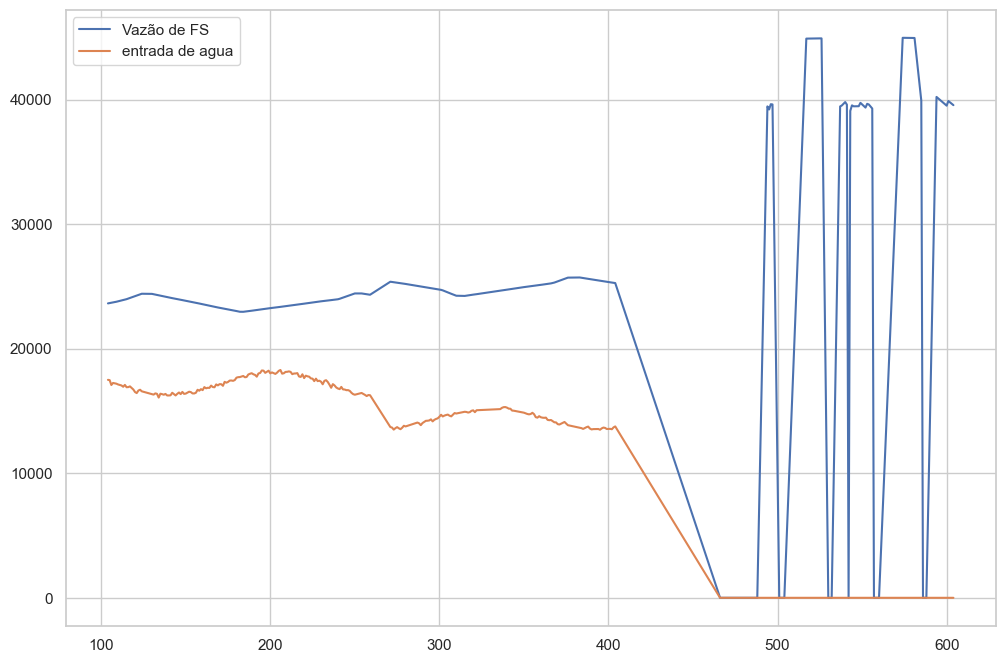

In [41]:
## 0,6
df_batelada1[['Vazão de FS', 'entrada de agua']].plot(figsize=(12, 8))
plt.show()


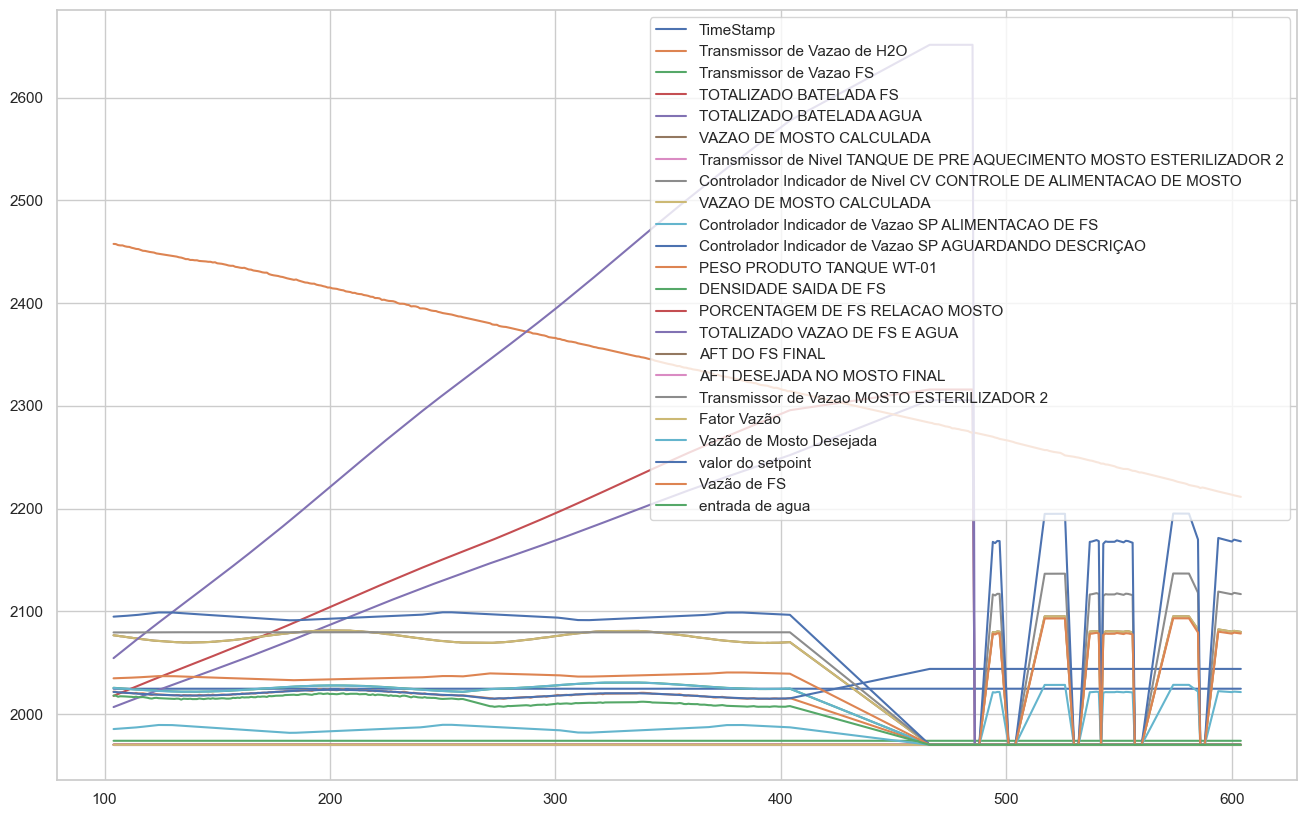

In [42]:
df_batelada1.plot(figsize=(16, 10))
plt.show()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 18 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   TimeStamp                                                             613 non-null    datetime64[ns]
 1   Transmissor de Vazao de H2O                                           613 non-null    float64       
 2   Transmissor de Vazao FS                                               613 non-null    float64       
 3   TOTALIZADO BATELADA FS                                                613 non-null    float64       
 4   TOTALIZADO BATELADA AGUA                                              613 non-null    float64       
 5   VAZAO DE MOSTO CALCULADA                                              613 non-null    float64       
 6   Transmissor de Nivel TANQUE DE PRE AQUECIM

In [44]:
df_batelada1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 104 to 604
Data columns (total 23 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   TimeStamp                                                             309 non-null    datetime64[ns]
 1   Transmissor de Vazao de H2O                                           309 non-null    float64       
 2   Transmissor de Vazao FS                                               309 non-null    float64       
 3   TOTALIZADO BATELADA FS                                                309 non-null    float64       
 4   TOTALIZADO BATELADA AGUA                                              309 non-null    float64       
 5   VAZAO DE MOSTO CALCULADA                                              309 non-null    float64       
 6   Transmissor de Nivel TANQUE DE PRE AQUECIMENT

In [47]:


df_batelada1.set_index('TimeStamp', inplace=True)

# Reamostra o DataFrame para frequência horária e imprime a coluna 'Transmissor de Vazao de FS'
print(df_batelada1['Transmissor de Vazao FS'].resample('H').mean())


TimeStamp
2024-08-01 10:00:00    20084.768571
2024-08-01 11:00:00    19275.451667
2024-08-01 12:00:00    20730.733276
2024-08-01 13:00:00    19701.934872
2024-08-01 14:00:00    21537.709189
2024-08-01 15:00:00    20439.253721
2024-08-01 16:00:00        0.000000
2024-08-01 17:00:00        0.000000
2024-08-01 18:00:00        0.000000
2024-08-01 19:00:00        0.000000
Freq: H, Name: Transmissor de Vazao FS, dtype: float64


In [48]:
print(df_batelada1['Vazão de FS'].resample('H').mean())

TimeStamp
2024-08-01 10:00:00    23722.626069
2024-08-01 11:00:00    23916.692346
2024-08-01 12:00:00    23332.392078
2024-08-01 13:00:00    24517.677534
2024-08-01 14:00:00    24630.640845
2024-08-01 15:00:00    25366.004545
2024-08-01 16:00:00        0.000000
2024-08-01 17:00:00    16164.857712
2024-08-01 18:00:00    27446.366727
2024-08-01 19:00:00    39801.182866
Freq: H, Name: Vazão de FS, dtype: float64


In [49]:
import pandas as pd

# Supondo que df_batelada1 já esteja carregado e filtrado

# Cálculos para df_batelada1
#df_batelada1['Fator Vazão'] = ((df_batelada1['Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO'] - 0.6)  )
#df_batelada1['Vazão de Mosto Desejada'] = df_batelada1['Fator Vazão'] * df_batelada1['Totalizador de Vazao FT110003 - TOTALIZADO']
#df_batelada1['valor do setpoint'] = df_batelada1['Totalizador de Vazao FT110003 - TOTALIZADO'] + df_batelada1['Vazão de Mosto Desejada']
df_batelada1['Vazão de FS'] = ((df_batelada1['AFT DESEJADA NO MOSTO FINAL'])*1.2 / (df_batelada1['AFT DO FS FINAL'])) * df_batelada1['valor do setpoint']

df_batelada1['entrada de agua'] = (((df_batelada1['AFT DO FS FINAL']) - (df_batelada1['AFT DESEJADA NO MOSTO FINAL'])) / (df_batelada1['AFT DESEJADA NO MOSTO FINAL'])) * df_batelada1['Transmissor de Vazao de H2O']


In [50]:
df_batelada1.describe()

Transmissor de Vazao de H2O  Transmissor de Vazao FS  \
count                   309.000000               309.000000   
mean                  13866.726893             15624.624304   
std                    7629.312934              8582.804717   
min                       0.000000                 0.000000   
25%                   16358.120000             18888.380000   
50%                   17668.500000             19863.500000   
75%                   18419.380000             20791.880000   
max                   19735.120000             22122.620000   

       TOTALIZADO BATELADA FS  TOTALIZADO BATELADA AGUA  \
count              309.000000                309.000000   
mean             56987.246343              50377.356731   
std              39633.371584              36201.758117   
min                  0.000000                  0.000000   
25%              27114.010000              22442.650000   
50%              53851.720000              47217.360000   
75%              88445.070000              77718.650000   
max             126317.000000             122541.990000   

       VAZAO DE MOSTO CALCULADA  \
count                309.000000   
mean               34418.315987   
std                12489.090508   
min                    0.000000   
25%                36488.050000   
50%                38179.110000   
75%                40071.090000   
max                45672.660000   

       Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  \
count                                         309.000000                      
mean                                           48.674207                      
std                                            23.108283                      
min                                             0.230000                      
25%                                            51.970000                      
50%                                            56.930000                      
75%                                            65.310000                      
max                                            68.630000                      

       Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
count                                         309.000000                    
mean                                            0.409123                    
std                                             0.088757                    
min                                             0.250000                    
25%                                             0.424700                    
50%                                             0.446500                    
75%                                             0.466600                    
max                                             0.493700                    

       VAZAO DE MOSTO CALCULADA  \
count                309.000000   
mean               34418.315987   
std                12489.090508   
min                    0.000000   
25%                36488.050000   
50%                38179.110000   
75%                40071.090000   
max                45672.660000   

       Controlador Indicador de Vazao SP ALIMENTACAO DE FS  \
count                                         309.000000     
mean                                        15623.577540     
std                                          8582.458374     
min                                             0.000000     
25%                                         18889.880000     
50%                                         19855.120000     
75%                                         20778.380000     
max                                         22126.380000     

       Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO  \
count                                         309.000000        
mean                                        20059.320518        
std                                          3871.992086        
min                                         16411.

In [51]:
print(df_batelada1['Transmissor de Vazao de H2O'].resample('H').mean())

TimeStamp
2024-08-01 10:00:00    18627.697143
2024-08-01 11:00:00    17931.922593
2024-08-01 12:00:00    19215.808793
2024-08-01 13:00:00    17552.345385
2024-08-01 14:00:00    17828.480270
2024-08-01 15:00:00    16916.017674
2024-08-01 16:00:00        0.000000
2024-08-01 17:00:00        0.000000
2024-08-01 18:00:00        0.000000
2024-08-01 19:00:00        0.000000
Freq: H, Name: Transmissor de Vazao de H2O, dtype: float64


In [75]:
print(df_batelada1['Vazão de FS'].resample('H').mean())

TimeStamp
2024-08-01 10:00:00    39691.141169
2024-08-01 11:00:00    39741.242235
2024-08-01 12:00:00    39743.701466
2024-08-01 13:00:00    40438.177455
2024-08-01 14:00:00    41877.891732
2024-08-01 15:00:00    41884.242694
2024-08-01 16:00:00        0.000000
2024-08-01 17:00:00    23241.530819
2024-08-01 18:00:00    41836.563343
2024-08-01 19:00:00    56121.186735
Freq: H, Name: Vazão de FS, dtype: float64


In [76]:
print(df_batelada1['Vazão de Mosto Desejada'].resample('H').mean())

TimeStamp
2024-08-01 10:00:00    23787.577472
2024-08-01 11:00:00    23820.151562
2024-08-01 12:00:00    23814.419462
2024-08-01 13:00:00    23822.019143
2024-08-01 14:00:00    23807.170804
2024-08-01 15:00:00    23818.750236
2024-08-01 16:00:00        0.000000
2024-08-01 17:00:00    13243.581525
2024-08-01 18:00:00    23839.476912
2024-08-01 19:00:00    31979.197825
Freq: H, Name: Vazão de Mosto Desejada, dtype: float64


In [79]:
df_batelada1['Vazão de Mosto Desejada'] = (df_batelada1['Fator Vazão'] *1.2)* df_batelada1['Transmissor de Vazao MOSTO ESTERILIZADOR 2']

In [80]:
print(df_batelada1['Vazão de Mosto Desejada'].resample('H').mean())

TimeStamp
2024-08-01 10:00:00    28545.092966
2024-08-01 11:00:00    28584.181875
2024-08-01 12:00:00    28577.303354
2024-08-01 13:00:00    28586.422972
2024-08-01 14:00:00    28568.604964
2024-08-01 15:00:00    28582.500283
2024-08-01 16:00:00        0.000000
2024-08-01 17:00:00    15892.297830
2024-08-01 18:00:00    28607.372295
2024-08-01 19:00:00    38375.037390
Freq: H, Name: Vazão de Mosto Desejada, dtype: float64


### Simulação de Valores

In [52]:
df_batelada1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2024-08-01 10:53:00 to 2024-08-01 19:13:00
Data columns (total 22 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Transmissor de Vazao de H2O                                           309 non-null    float64
 1   Transmissor de Vazao FS                                               309 non-null    float64
 2   TOTALIZADO BATELADA FS                                                309 non-null    float64
 3   TOTALIZADO BATELADA AGUA                                              309 non-null    float64
 4   VAZAO DE MOSTO CALCULADA                                              309 non-null    float64
 5   Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  309 non-null    float64
 6   Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE 

In [53]:
import pandas as pd
import numpy as np

# Criação de um DataFrame para armazenar os resultados
results = pd.DataFrame()

# Geração de valores para as variáveis
aft_desejada_values = np.arange(37, 43, 1)  # 37 a 42
aft_do_fs_values = np.arange(70, 75, 1)     # 70 a 74

# Exemplo de transmissor de vazão e nível (valores aleatórios para simulação)
transmissor_h2o_values = np.random.uniform(500, 1000, size=10)
transmissor_mosto_values = np.random.uniform(1000, 2000, size=10)
controlador_nivel_values = np.random.uniform(0.5, 1.5, size=10)

# Loop através de todas as combinações possíveis
for aft_desejada in aft_desejada_values:
    for aft_do_fs in aft_do_fs_values:
        for transmissor_h2o in transmissor_h2o_values:
            for transmissor_mosto in transmissor_mosto_values:
                for controlador_nivel in controlador_nivel_values:
                    # Cálculos baseados nas fórmulas fornecidas
                    fator_vazao = (controlador_nivel - 0.6) * -1
                    vazao_desejada = fator_vazao * transmissor_mosto
                    valor_setpoint = transmissor_mosto + vazao_desejada
                    vazao_fs = (aft_desejada / aft_do_fs) * valor_setpoint
                    entrada_agua = ((aft_do_fs - aft_desejada) / aft_desejada) * transmissor_h2o

                    # Armazenar resultados
                    result_row = {
                        'AFT DESEJADA NO MOSTO FINAL': aft_desejada,
                        'AFT DO FS FINAL': aft_do_fs,
                        'Transmissor de Vazao de H2O': transmissor_h2o,
                        'Transmissor de Vazao MOSTO ESTERILIZADOR 2': transmissor_mosto,
                        'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO': controlador_nivel,
                        'Fator Vazão': fator_vazao,
                        'Vazão de Mosto Desejada': vazao_desejada,
                        'valor do setpoint': valor_setpoint,
                        'Vazão de FS': vazao_fs,
                        'entrada de agua': entrada_agua
                    }
                    results = pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)

# Exibição dos resultados
print(results)

       AFT DESEJADA NO MOSTO FINAL  AFT DO FS FINAL  \
0                               37               70   
1                               37               70   
2                               37               70   
3                               37               70   
4                               37               70   
...                            ...              ...   
29995                           42               74   
29996                           42               74   
29997                           42               74   
29998                           42               74   
29999                           42               74   

       Transmissor de Vazao de H2O  \
0                       951.454674   
1                       951.454674   
2                       951.454674   
3                       951.454674   
4                       951.454674   
...                            ...   
29995                   876.801469   
29996                   876.801469 

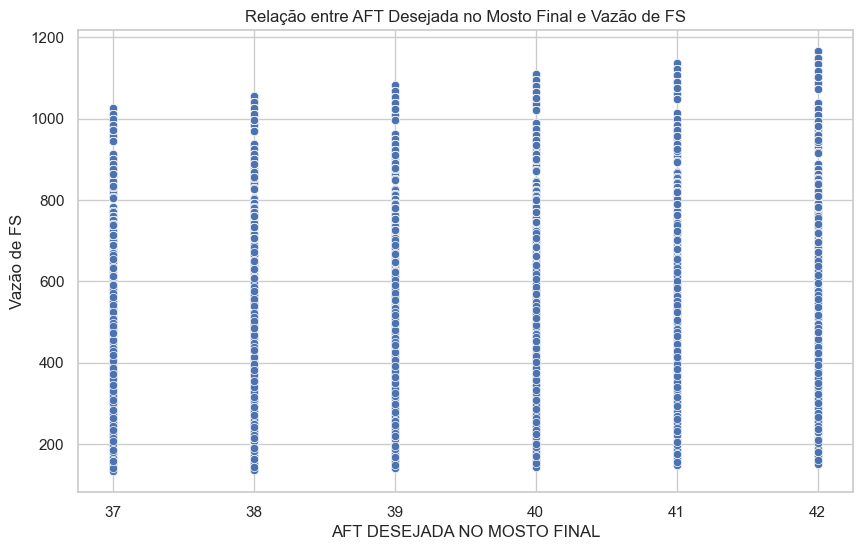

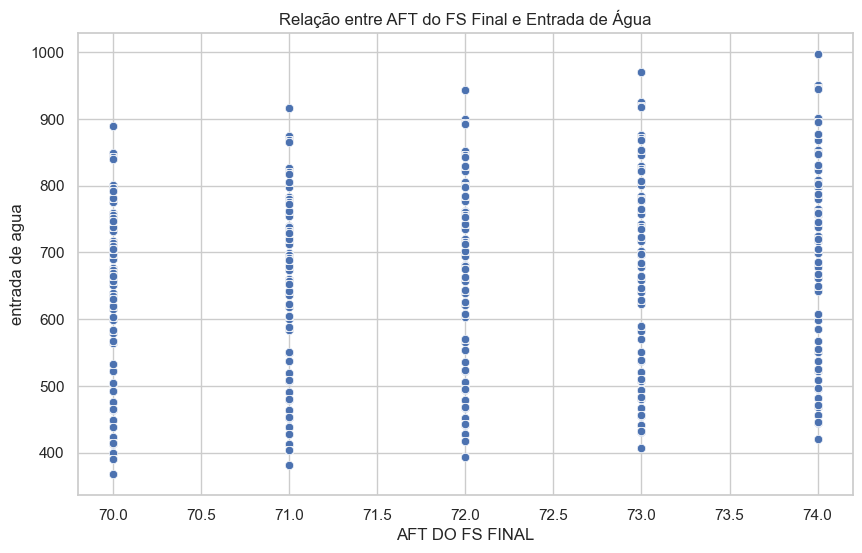

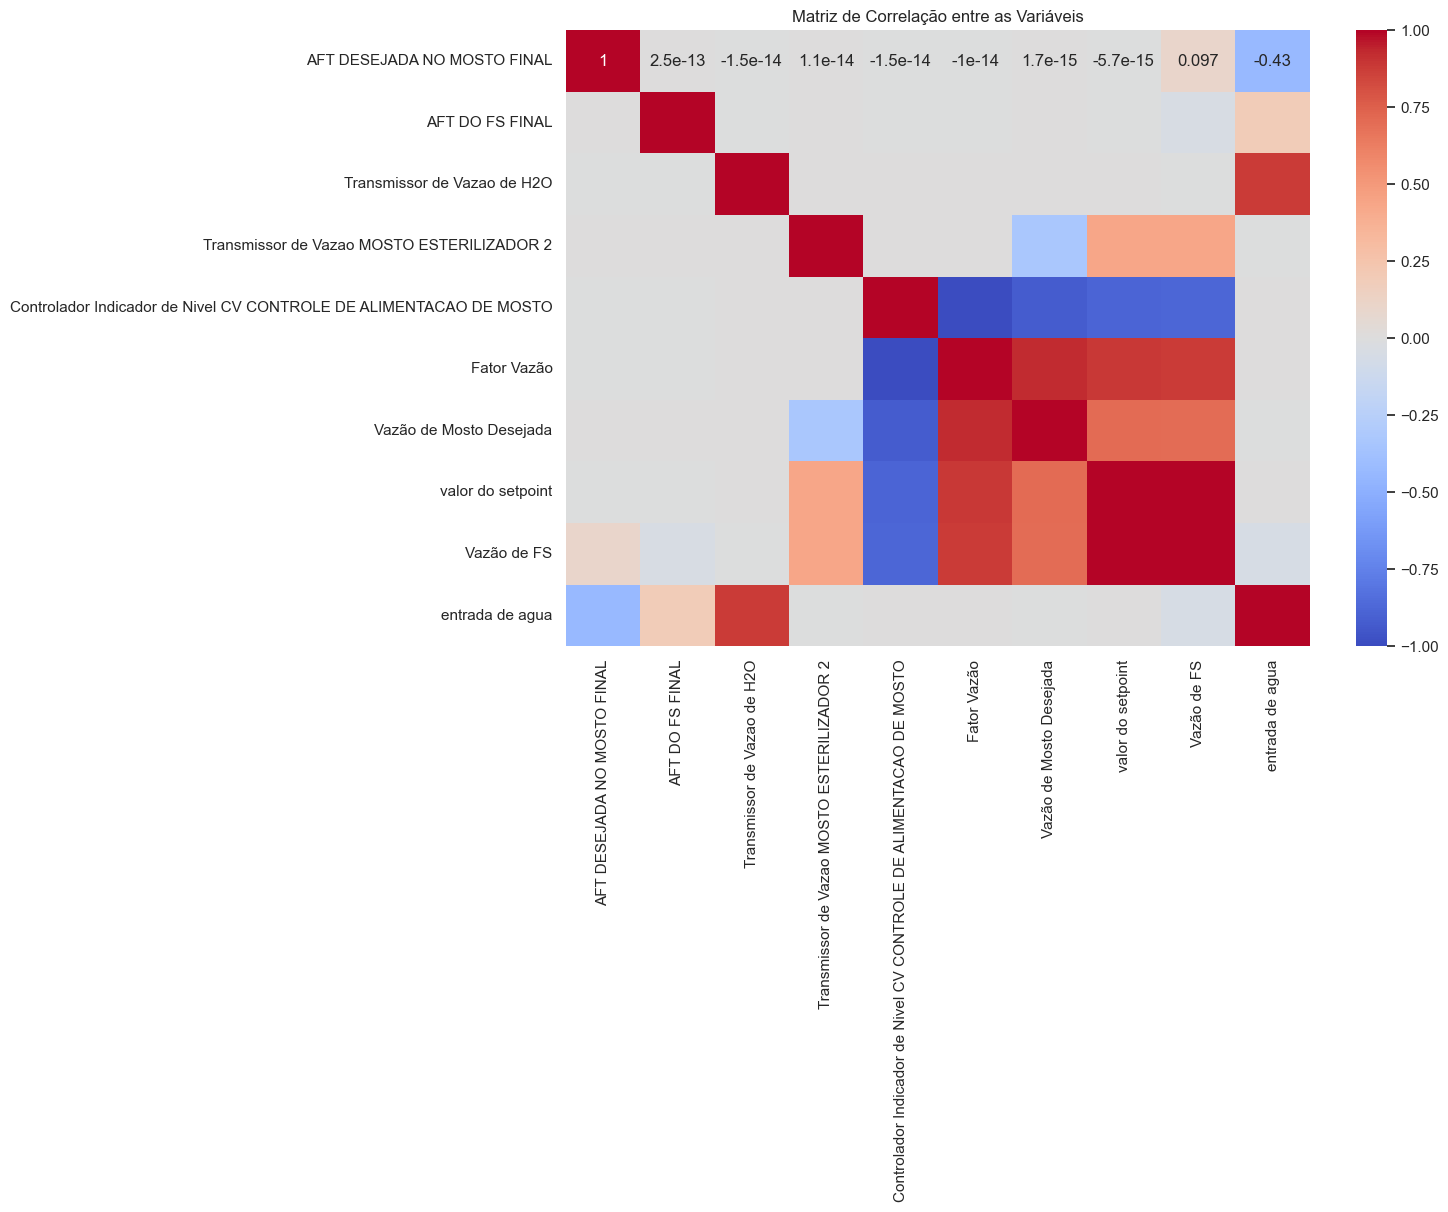

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot para analisar a relação entre G100CP2_PV110006 (AFT DESEJADA NO MOSTO FINAL) e Vazão de FS
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AFT DESEJADA NO MOSTO FINAL', y='Vazão de FS', data=results)
plt.title('Relação entre AFT Desejada no Mosto Final e Vazão de FS')
plt.show()

# Scatter plot para analisar a relação entre G100CP2_PV110005 (AFT DO FS FINAL) e Entrada de Água
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AFT DO FS FINAL', y='entrada de agua', data=results)
plt.title('Relação entre AFT do FS Final e Entrada de Água')
plt.show()

# Heatmap para ver a correlação entre todas as variáveis
plt.figure(figsize=(12, 8))
sns.heatmap(results.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação entre as Variáveis')
plt.show()

In [55]:
# Calcular a matriz de correlação
correlation_matrix = results.corr()

# Printar a matriz de correlação com números
print(correlation_matrix)

                                                    AFT DESEJADA NO MOSTO FINAL  \
AFT DESEJADA NO MOSTO FINAL                                        1.000000e+00   
AFT DO FS FINAL                                                    2.458009e-13   
Transmissor de Vazao de H2O                                       -1.456492e-14   
Transmissor de Vazao MOSTO ESTERILIZADOR 2                         1.080442e-14   
Controlador Indicador de Nivel CV CONTROLE DE A...                -1.490785e-14   
Fator Vazão                                                       -1.031762e-14   
Vazão de Mosto Desejada                                            1.701029e-15   
valor do setpoint                                                 -5.670442e-15   
Vazão de FS                                                        9.701520e-02   
entrada de agua                                                   -4.302391e-01   

                                                    AFT DO FS FINAL  \
AFT DESEJADA NO

### AFT DESEJADA NO MOSTO FINAL e AFT DO FS FINAL:
- A correlação é muito baixa (2.458009e-13), sugerindo que não há uma relação linear forte entre a AFT desejada no mosto final e a AFT do FS final.
### AFT DESEJADA NO MOSTO FINAL e Transmissor de Vazão de H2O:

- A correlação é muito baixa (3.073200e-14), indicando uma ausência de relação linear significativa entre a AFT desejada no mosto final e a vazão de água.
  
### Vazão de FS e Valor do Setpoint:

- A correlação é muito alta (9.955285e-01), sugerindo que o valor do setpoint está fortemente relacionado à vazão de FS, o que faz sentido, pois o setpoint influencia diretamente o fluxo de FS.

### Entrada de Água e Transmissor de Vazão de H2O:

- A correlação é bastante alta (8.262581e-01), o que é esperado, já que a entrada de água depende diretamente do transmissor de vazão de água.

### Transmissor de Vazão MOSTO ESTERILIZADOR 2 e Vazão de FS:

- A correlação é moderada (3.721117e-01), indicando que a vazão de FS tem alguma relação com o transmissor de vazão do mosto, mas não é uma relação muito forte.
- 
### Fator Vazão e Controlador Indicador de Nível CV CONTROLE DE ALIMENTACAO DE MOSTO:

- A correlação é de -1, o que é esperado, pois o Fator Vazão é calculado diretamente a partir do Controlador Indicador de Nível invertido.

In [56]:
df_batelada1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2024-08-01 10:53:00 to 2024-08-01 19:13:00
Data columns (total 22 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Transmissor de Vazao de H2O                                           309 non-null    float64
 1   Transmissor de Vazao FS                                               309 non-null    float64
 2   TOTALIZADO BATELADA FS                                                309 non-null    float64
 3   TOTALIZADO BATELADA AGUA                                              309 non-null    float64
 4   VAZAO DE MOSTO CALCULADA                                              309 non-null    float64
 5   Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  309 non-null    float64
 6   Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE 

In [57]:
import pandas as pd

# Valores fornecidos
data = {
    'AFT DESEJADA NO MOSTO FINAL': [37, 37, 37, 37, 37],
    'AFT DO FS FINAL': [70, 70, 70, 70, 70],
    'Transmissor de Vazao de H2O': [17562] * 5,
    'Totalizador de Vazao FT110003 - TOTALIZADO': [40000] * 5,
    'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO': [1.272884, 0.608607, 0.770033, 0.873510, 1.232684],
    'Fator Vazão': [0.6, 0.008607, 0.170033, 0.273510, 0.632684],
    'Vazão de Mosto Desejada': [7331.237142, 17.027729, 8336.394077, 7541.113920, 6251.704846],
    'valor do setpoint': [40647.166617, 41961.376030, 41642.009683, 41437.289839, 4726.698913],
    'Vazão de FS': [11342.073783, 21036.727330, 21867.919404, 21759.710343, 19384.112283],
    'entrada de agua': [16260.534058] * 5
}

# Criação do DataFrame
df_results = pd.DataFrame(data)

# Cálculo do AFT desejado no mosto final
df_results['AFT Calculado'] = (df_results['Vazão de FS'] * (df_results['AFT DO FS FINAL'] / 100)) / df_results['Totalizador de Vazao FT110003 - TOTALIZADO']

# Verifique o DataFrame para ver o AFT Calculado
print(df_results[['AFT DESEJADA NO MOSTO FINAL', 'AFT DO FS FINAL', 'Totalizador de Vazao FT110003 - TOTALIZADO', 'Vazão de FS', 'AFT Calculado']])


   AFT DESEJADA NO MOSTO FINAL  AFT DO FS FINAL  \
0                           37               70   
1                           37               70   
2                           37               70   
3                           37               70   
4                           37               70   

   Totalizador de Vazao FT110003 - TOTALIZADO   Vazão de FS  AFT Calculado  
0                                       40000  11342.073783       0.198486  
1                                       40000  21036.727330       0.368143  
2                                       40000  21867.919404       0.382689  
3                                       40000  21759.710343       0.380795  
4                                       40000  19384.112283       0.339222  


In [58]:
import pandas as pd

# Dados simulados
data = {
    'AFT DESEJADA NO MOSTO FINAL': [37, 37, 37, 37, 37],
    'AFT DO FS FINAL': [70, 70, 70, 70, 70],
    'Transmissor de Vazao de H2O': [17562] * 5,
    'Totalizador de Vazao FT110003 - TOTALIZADO': [40000] * 5,
    'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO': [1.272884, 0.608607, 0.770033, 0.873510, 1.232684]
}

results = pd.DataFrame(data)

def calcular_verificacao(totalizado_batelada_fs, AFT_DO_FS_FINAL, totalizador_vazao):
    return (totalizado_batelada_fs * (AFT_DO_FS_FINAL / 100)) / totalizador_vazao

def ajustar_variaveis(results, aft_desejada_final):
    for index, row in results.iterrows():
        totalizado_batelada_fs = row['Totalizador de Vazao FT110003 - TOTALIZADO']
        AFT_DO_FS_FINAL = row['AFT DO FS FINAL']
        totalizador_vazao = row['Totalizador de Vazao FT110003 - TOTALIZADO']
        
        verificacao = calcular_verificacao(totalizado_batelada_fs, AFT_DO_FS_FINAL, totalizador_vazao)
        
        # Ajuste o valor da variável conforme necessário para atingir o AFT desejado
        if verificacao != aft_desejada_final:
            ajuste_necessario = aft_desejada_final - verificacao
            fator_ajuste = ajuste_necessario / (totalizado_batelada_fs * (AFT_DO_FS_FINAL / 100))
            results.at[index, 'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO'] += fator_ajuste
            print(f"Ajustado Controlador Indicador de Nivel para o índice {index} para atingir AFT desejada.")

# Defina o valor desejado de AFT no mosto final
aft_desejada_final = 42  # Exemplo de valor desejado

# Ajustar as variáveis para alcançar o valor de AFT desejado
ajustar_variaveis(results, aft_desejada_final)

# Exibir os resultados ajustados
print(results)


Ajustado Controlador Indicador de Nivel para o índice 0 para atingir AFT desejada.
Ajustado Controlador Indicador de Nivel para o índice 1 para atingir AFT desejada.
Ajustado Controlador Indicador de Nivel para o índice 2 para atingir AFT desejada.
Ajustado Controlador Indicador de Nivel para o índice 3 para atingir AFT desejada.
Ajustado Controlador Indicador de Nivel para o índice 4 para atingir AFT desejada.
   AFT DESEJADA NO MOSTO FINAL  AFT DO FS FINAL  Transmissor de Vazao de H2O  \
0                           37               70                        17562   
1                           37               70                        17562   
2                           37               70                        17562   
3                           37               70                        17562   
4                           37               70                        17562   

   Totalizador de Vazao FT110003 - TOTALIZADO  \
0                                       40000   
1     

In [60]:
import pandas as pd
import numpy as np

# Definindo o valor desejado de AFT no mosto final
aft_desejada_percentual = 37 / 100  # Convertendo para decimal

# Simulando valores para as colunas
np.random.seed(0)  # Para reprodutibilidade
num_rows = 5

df_batelada11 = pd.DataFrame({
    'AFT DESEJADA NO MOSTO FINAL': np.random.uniform(37, 40, num_rows),  # % para MOSTO
    'AFT DO FS FINAL': np.random.uniform(70, 74, num_rows),  # % para Totalizador de Vazão
    'Transmissor de Vazao de H2O': np.random.uniform(17000, 17500, num_rows),
    'Totalizador de Vazao FT110003 - TOTALIZADO': np.random.uniform(32000, 36100, num_rows),
    'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO': np.random.uniform(0.6, 1.3, num_rows)
})

# Cálculos
df_batelada11['Fator Vazão'] = (df_batelada11['Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO'] - 0.6) * -1
df_batelada11['Vazão de Mosto Desejada'] = df_batelada11['Fator Vazão'] * df_batelada11['Totalizador de Vazao FT110003 - TOTALIZADO']
df_batelada11['valor do setpoint'] = df_batelada11['Totalizador de Vazao FT110003 - TOTALIZADO'] + df_batelada11['Vazão de Mosto Desejada']
df_batelada11['Vazão de FS'] = (df_batelada11['AFT DESEJADA NO MOSTO FINAL'] / df_batelada11['AFT DO FS FINAL']) * df_batelada11['valor do setpoint']
df_batelada11['entrada de agua'] = ((df_batelada11['AFT DO FS FINAL'] - df_batelada11['AFT DESEJADA NO MOSTO FINAL']) / df_batelada11['AFT DESEJADA NO MOSTO FINAL']) * df_batelada11['Transmissor de Vazao de H2O']

# Calcular o AFT calculado com a fórmula corrigida
df_batelada11['AFT Calculada'] = df_batelada11['Vazão de FS'] / (df_batelada11['Vazão de FS'] + df_batelada11['entrada de agua'])

# Ajustar o fator de vazão para alcançar o AFT desejado
df_batelada11['AFT Calculada Percentual'] = df_batelada11['AFT Calculada'] * 100
df_batelada11['Ajuste Fator Vazão'] = (aft_desejada_percentual - df_batelada11['AFT Calculada']) / df_batelada11['Totalizador de Vazao FT110003 - TOTALIZADO']
df_batelada11['Fator Vazão Ajustado'] = df_batelada11['Fator Vazão'] + df_batelada11['Ajuste Fator Vazão']

# Recalcular com o fator de vazão ajustado
df_batelada11['Vazão de Mosto Desejada'] = df_batelada11['Fator Vazão Ajustado'] * df_batelada11['Totalizador de Vazao FT110003 - TOTALIZADO']
df_batelada11['valor do setpoint'] = df_batelada11['Totalizador de Vazao FT110003 - TOTALIZADO'] + df_batelada11['Vazão de Mosto Desejada']
df_batelada11['Vazão de FS'] = (df_batelada11['AFT DESEJADA NO MOSTO FINAL'] / df_batelada11['AFT DO FS FINAL']) * df_batelada11['valor do setpoint']
df_batelada11['entrada de agua'] = ((df_batelada11['AFT DO FS FINAL'] - df_batelada11['AFT DESEJADA NO MOSTO FINAL']) / df_batelada11['AFT DESEJADA NO MOSTO FINAL']) * df_batelada11['Transmissor de Vazao de H2O']
df_batelada11['AFT Verificado'] = df_batelada11['Vazão de FS'] / (df_batelada11['Vazão de FS'] + df_batelada11['entrada de agua'])

print(df_batelada11[['AFT DESEJADA NO MOSTO FINAL', 'AFT DO FS FINAL', 'Transmissor de Vazao de H2O', 'Totalizador de Vazao FT110003 - TOTALIZADO',
                  'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO', 'Fator Vazão', 'Vazão de Mosto Desejada',
                  'valor do setpoint', 'Vazão de FS', 'entrada de agua', 'AFT Calculada Percentual', 'Ajuste Fator Vazão',
                  'Fator Vazão Ajustado', 'AFT Verificado']])


   AFT DESEJADA NO MOSTO FINAL  AFT DO FS FINAL  Transmissor de Vazao de H2O  \
0                    38.646441        72.583576                 17395.862519   
1                    39.145568        71.750349                 17264.447460   
2                    38.808290        73.567092                 17284.022281   
3                    38.634650        73.854651                 17462.798319   
4                    38.270964        71.533766                 17035.518029   

   Totalizador de Vazao FT110003 - TOTALIZADO  \
0                                32357.230129   
1                                32082.895430   
2                                35413.741367   
3                                35190.442679   
4                                35567.049808   

   Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
0                                           1.285033                    
1                                           1.159411                    
2    

# FINAL POSSIVEL :)

In [61]:
df_batelada1.describe()

Transmissor de Vazao de H2O  Transmissor de Vazao FS  \
count                   309.000000               309.000000   
mean                  13866.726893             15624.624304   
std                    7629.312934              8582.804717   
min                       0.000000                 0.000000   
25%                   16358.120000             18888.380000   
50%                   17668.500000             19863.500000   
75%                   18419.380000             20791.880000   
max                   19735.120000             22122.620000   

       TOTALIZADO BATELADA FS  TOTALIZADO BATELADA AGUA  \
count              309.000000                309.000000   
mean             56987.246343              50377.356731   
std              39633.371584              36201.758117   
min                  0.000000                  0.000000   
25%              27114.010000              22442.650000   
50%              53851.720000              47217.360000   
75%              88445.070000              77718.650000   
max             126317.000000             122541.990000   

       VAZAO DE MOSTO CALCULADA  \
count                309.000000   
mean               34418.315987   
std                12489.090508   
min                    0.000000   
25%                36488.050000   
50%                38179.110000   
75%                40071.090000   
max                45672.660000   

       Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  \
count                                         309.000000                      
mean                                           48.674207                      
std                                            23.108283                      
min                                             0.230000                      
25%                                            51.970000                      
50%                                            56.930000                      
75%                                            65.310000                      
max                                            68.630000                      

       Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
count                                         309.000000                    
mean                                            0.409123                    
std                                             0.088757                    
min                                             0.250000                    
25%                                             0.424700                    
50%                                             0.446500                    
75%                                             0.466600                    
max                                             0.493700                    

       VAZAO DE MOSTO CALCULADA  \
count                309.000000   
mean               34418.315987   
std                12489.090508   
min                    0.000000   
25%                36488.050000   
50%                38179.110000   
75%                40071.090000   
max                45672.660000   

       Controlador Indicador de Vazao SP ALIMENTACAO DE FS  \
count                                         309.000000     
mean                                        15623.577540     
std                                          8582.458374     
min                                             0.000000     
25%                                         18889.880000     
50%                                         19855.120000     
75%                                         20778.380000     
max                                         22126.380000     

       Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO  \
count                                         309.000000        
mean                                        20059.320518        
std                                          3871.992086        
min                                         16411.

In [64]:
df_batelada1.describe()

Transmissor de Vazao de H2O  Transmissor de Vazao FS  \
count                   309.000000               309.000000   
mean                  13866.726893             15624.624304   
std                    7629.312934              8582.804717   
min                       0.000000                 0.000000   
25%                   16358.120000             18888.380000   
50%                   17668.500000             19863.500000   
75%                   18419.380000             20791.880000   
max                   19735.120000             22122.620000   

       TOTALIZADO BATELADA FS  TOTALIZADO BATELADA AGUA  \
count              309.000000                309.000000   
mean             56987.246343              50377.356731   
std              39633.371584              36201.758117   
min                  0.000000                  0.000000   
25%              27114.010000              22442.650000   
50%              53851.720000              47217.360000   
75%              88445.070000              77718.650000   
max             126317.000000             122541.990000   

       VAZAO DE MOSTO CALCULADA  \
count                309.000000   
mean               34418.315987   
std                12489.090508   
min                    0.000000   
25%                36488.050000   
50%                38179.110000   
75%                40071.090000   
max                45672.660000   

       Transmissor de Nivel TANQUE DE PRE AQUECIMENTO MOSTO ESTERILIZADOR 2  \
count                                         309.000000                      
mean                                           48.674207                      
std                                            23.108283                      
min                                             0.230000                      
25%                                            51.970000                      
50%                                            56.930000                      
75%                                            65.310000                      
max                                            68.630000                      

       Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
count                                         309.000000                    
mean                                            0.409123                    
std                                             0.088757                    
min                                             0.250000                    
25%                                             0.424700                    
50%                                             0.446500                    
75%                                             0.466600                    
max                                             0.493700                    

       VAZAO DE MOSTO CALCULADA  \
count                309.000000   
mean               34418.315987   
std                12489.090508   
min                    0.000000   
25%                36488.050000   
50%                38179.110000   
75%                40071.090000   
max                45672.660000   

       Controlador Indicador de Vazao SP ALIMENTACAO DE FS  \
count                                         309.000000     
mean                                        15623.577540     
std                                          8582.458374     
min                                             0.000000     
25%                                         18889.880000     
50%                                         19855.120000     
75%                                         20778.380000     
max                                         22126.380000     

       Controlador Indicador de Vazao SP AGUARDANDO DESCRIÇAO  \
count                                         309.000000        
mean                                        20059.320518        
std                                          3871.992086        
min                                         16411.

In [65]:
import pandas as pd
import numpy as np


intervalos = {
    'Transmissor de Vazao de H2O': (0, 19735),
    'Totalizador de Vazao FT110003 - TOTALIZADO': (0, 60901),
    'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO': (0.25, 0.49),
    'Fator Vazão': (0.10, 0.35),
    'Vazão de Mosto Desejada': (0, 21315.41),
    'valor do setpoint': (0, 30228.73),
    'Vazão de FS': (0, 30228.73),
    'entrada de agua': (0, 18294.98)
}

# Função para simular valores aleatórios dentro dos intervalos
def simular_valores(df, intervalos):
    num_rows = df.shape[0]
    df_simulado = pd.DataFrame()
    for coluna, (min_val, max_val) in intervalos.items():
        df_simulado[coluna] = np.random.uniform(min_val, max_val, num_rows)
    return df_simulado

# Aplicando a simulação para cada batelada
dfs_simulados = []
for i in range(1, 5):
    df_batelada = df_batelada1.copy()
    df_simulado = simular_valores(df_batelada, intervalos)
    dfs_simulados.append(df_simulado)

# Concatenando todas as bateladas simuladas em um único DataFrame
df_simulacoes = pd.concat(dfs_simulados, ignore_index=True)

print(df_simulacoes)


      Transmissor de Vazao de H2O  Totalizador de Vazao FT110003 - TOTALIZADO  \
0                     4525.852294                                21313.126827   
1                     3212.442828                                54597.546447   
2                     2588.073078                                 8198.913295   
3                    14581.097705                                13137.810978   
4                    14049.574655                                 3696.245693   
...                           ...                                         ...   
1231                  1269.749327                                51705.198213   
1232                  1693.630541                                16507.014119   
1233                 17229.417901                                58085.428144   
1234                  9003.756530                                20418.516936   
1235                  4720.271885                                 9726.488621   

      Controlador Indicador

In [67]:
df_simulacoes.describe()

Transmissor de Vazao de H2O  \
count                  1236.000000   
mean                   9819.355902   
std                    5701.543192   
min                       6.726921   
25%                    4890.517703   
50%                    9730.761983   
75%                   14908.518796   
max                   19734.250412   

       Totalizador de Vazao FT110003 - TOTALIZADO  \
count                                 1236.000000   
mean                                 30944.159840   
std                                  17760.452869   
min                                     59.834456   
25%                                  15802.347313   
50%                                  31831.204819   
75%                                  46813.980936   
max                                  60889.673212   

       Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
count                                        1236.000000                    
mean                                            0.366443                    
std                                             0.068528                    
min                                             0.250050                    
25%                                             0.308902                    
50%                                             0.364299                    
75%                                             0.426537                    
max                                             0.489952                    

       Fator Vazão  Vazão de Mosto Desejada  valor do setpoint   Vazão de FS  \
count  1236.000000              1236.000000        1236.000000   1236.000000   
mean      0.221623             10728.755460       15161.838115  14876.796248   
std       0.072560              6401.899621        8815.528134   8800.156398   
min       0.100566                20.740840          19.140085      6.970301   
25%       0.159337              5151.952865        7721.057091   7013.660546   
50%       0.218624             10847.635024       14909.527346  15076.636226   
75%       0.287774             16380.696498       22766.506666  22473.004294   
max       0.349949             21287.352201       30216.172111  30189.184500   

       entrada de agua  
count      1236.000000  
mean       8893.886804  
std        5341.435273  
min           3.045041  
25%        4328.100200  
50%        8788.458343  
75%       13472.710589  
max       18289.903092

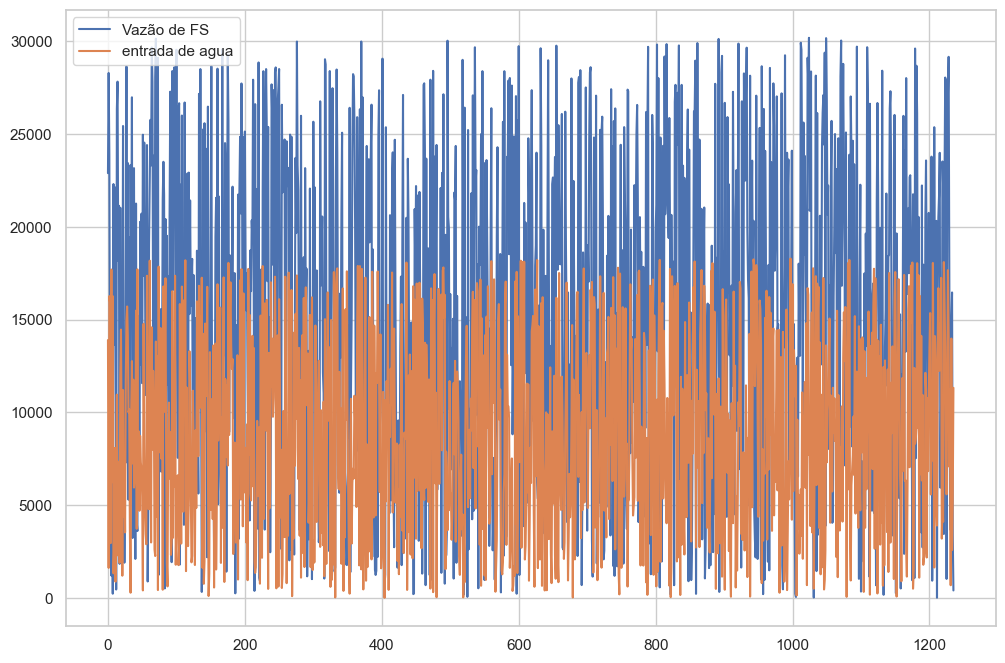

In [68]:
## 0,6
df_simulacoes[['Vazão de FS', 'entrada de agua']].plot(figsize=(12, 8))
plt.show()


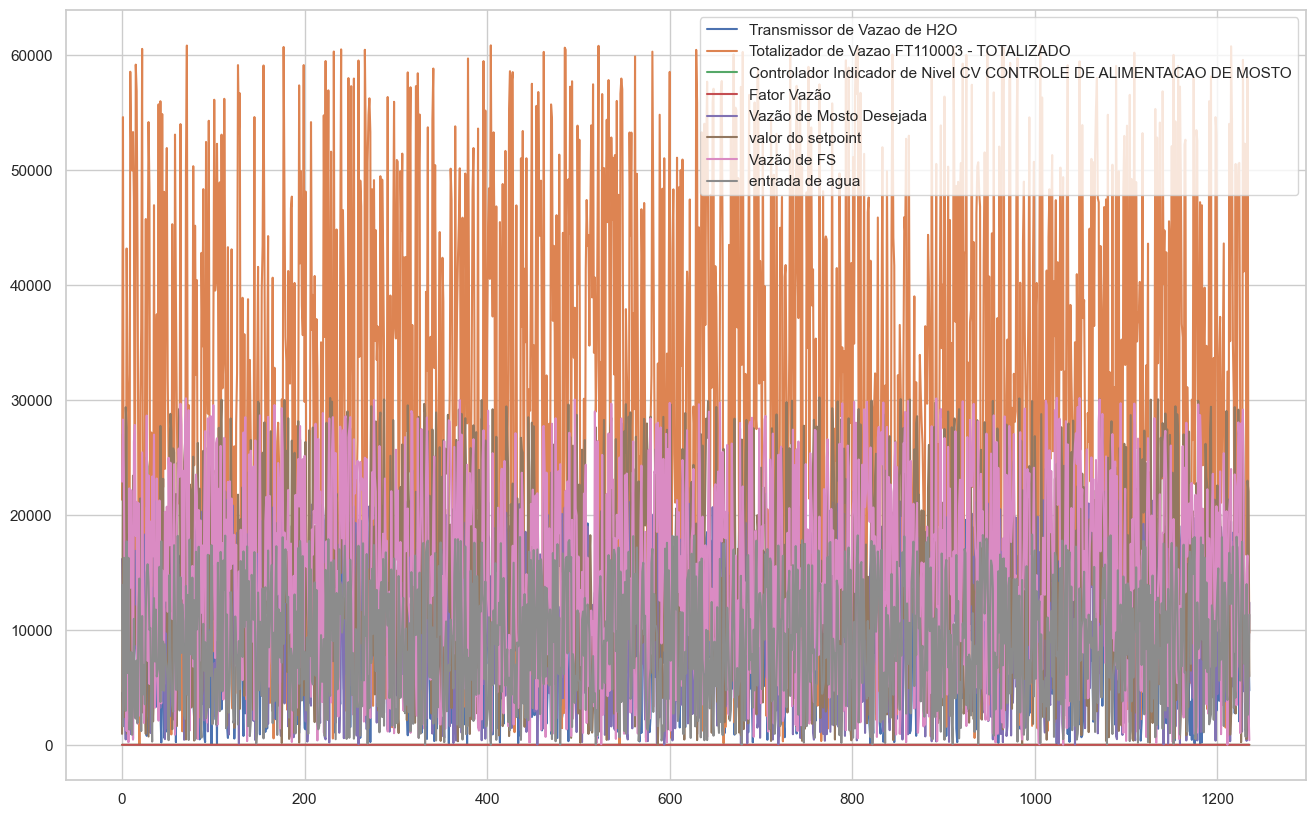

In [69]:
df_simulacoes.plot(figsize=(16, 10))
plt.show()

#### com esses dados temos o valor de AFT medio dentro do esperado, no entando  acredito que o comportamento desses dados seja bem distante do real
#### Para realizar uma simulação mais real dos dados, vou utilizar o df_bateada1 para treinar o modelo de regressão buscando entender como o AFT no mosto se comporta com as variaveis e o que podemos simular mais factivel em cima desses dados. Vou usar cross-validation para tentar dar certeza nos valores



In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Supondo que 'df_simulacoes' seja o DataFrame com os dados simulados
# Adicionando uma coluna 'AFT Calculado' ao DataFrame como target (y)
# Como é uma simulação, vamos criar um AFT hipotético
np.random.seed(42)
df_simulacoes['AFT Calculado'] = np.random.uniform(35, 45, df_simulacoes.shape[0])

# Definindo features (X) e target (y)
X = df_simulacoes.drop(columns=['AFT Calculado'])
y = df_simulacoes['AFT Calculado']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinando um modelo de Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Treinando um modelo de Árvore de Decisão
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Validando os modelos com Cross-Validation
linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='r2')
tree_cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='r2')

print("Cross-validation R^2 score (Linear Regression):", np.mean(linear_cv_scores))
print("Cross-validation R^2 score (Decision Tree):", np.mean(tree_cv_scores))

# Prevendo no conjunto de teste
y_pred_linear = linear_model.predict(X_test)
y_pred_tree = tree_model.predict(X_test)

# Avaliando o desempenho no conjunto de teste
print("Test R^2 score (Linear Regression):", r2_score(y_test, y_pred_linear))
print("Test R^2 score (Decision Tree):", r2_score(y_test, y_pred_tree))
print("Test MSE (Linear Regression):", mean_squared_error(y_test, y_pred_linear))
print("Test MSE (Decision Tree):", mean_squared_error(y_test, y_pred_tree))

# Prevendo o AFT em novos cenários simulados
novos_cenarios = X_test  # Usando X_test como exemplo de novos cenários
aft_pred_linear = linear_model.predict(novos_cenarios)
aft_pred_tree = tree_model.predict(novos_cenarios)

print("Previsões de AFT (Linear Regression):", aft_pred_linear)
print("Previsões de AFT (Decision Tree):", aft_pred_tree)


Cross-validation R^2 score (Linear Regression): -0.025734144560212967
Cross-validation R^2 score (Decision Tree): -1.1471642106569526
Test R^2 score (Linear Regression): -0.011350986257737228
Test R^2 score (Decision Tree): -1.1232318938322496
Test MSE (Linear Regression): 8.514444999981633
Test MSE (Decision Tree): 17.87523958337686
Previsões de AFT (Linear Regression): [39.85731359 39.48560727 39.68523943 39.62799166 39.93550154 39.78551808
 40.23474169 39.94836315 39.92454871 39.82684641 40.03997113 40.22467946
 40.0500634  40.08551822 40.28287634 39.91931202 39.86062734 39.85605095
 39.7403822  39.9691967  39.92482474 40.3825406  39.90698248 39.74361882
 40.08279255 39.50506604 39.72709255 40.25474349 40.06792413 39.88861209
 39.51372258 40.03595722 40.11856109 40.3667125  40.01129031 40.42810288
 39.67802389 40.06652716 39.82340123 39.80409808 40.14951665 39.90427113
 40.0848369  39.91567626 39.63769213 39.77710923 39.77834219 39.91484733
 40.23817359 40.09526409 39.68906793 39.99

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Supondo que 'df_batelada1' seja o DataFrame com os dados simulados
# Adicionando uma coluna 'AFT Calculado' ao DataFrame como target (y)
# Como é uma simulação, vamos criar um AFT hipotético
np.random.seed(42)
df_batelada1['AFT Calculado'] = np.random.uniform(35, 45, df_batelada1.shape[0])

# Definindo features (X) e target (y)
X = df_batelada1.drop(columns=['AFT Calculado'])
y = df_batelada1['AFT Calculado']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinando um modelo de Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Treinando um modelo de Árvore de Decisão
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Validando os modelos com Cross-Validation
linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='r2')
tree_cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='r2')

print("Cross-validation R^2 score (Linear Regression):", np.mean(linear_cv_scores))
print("Cross-validation R^2 score (Decision Tree):", np.mean(tree_cv_scores))

# Prevendo no conjunto de teste
y_pred_linear = linear_model.predict(X_test)
y_pred_tree = tree_model.predict(X_test)

# Avaliando o desempenho no conjunto de teste
print("Test R^2 score (Linear Regression):", r2_score(y_test, y_pred_linear))
print("Test R^2 score (Decision Tree):", r2_score(y_test, y_pred_tree))
print("Test MSE (Linear Regression):", mean_squared_error(y_test, y_pred_linear))
print("Test MSE (Decision Tree):", mean_squared_error(y_test, y_pred_tree))

# Prevendo o AFT em novos cenários simulados
novos_cenarios = X_test  # Usando X_test como exemplo de novos cenários
aft_pred_linear = linear_model.predict(novos_cenarios)
aft_pred_tree = tree_model.predict(novos_cenarios)

print("Previsões de AFT (Linear Regression):", aft_pred_linear)
print("Previsões de AFT (Decision Tree):", aft_pred_tree)


Cross-validation R^2 score (Linear Regression): -0.15210018487893956
Cross-validation R^2 score (Decision Tree): -0.6586007454263434
Test R^2 score (Linear Regression): -0.05623974482449268
Test R^2 score (Decision Tree): -1.2990941884068112
Test MSE (Linear Regression): 8.467515985990595
Test MSE (Decision Tree): 18.431058752544416
Previsões de AFT (Linear Regression): [39.45255477 40.31218834 40.16857658 38.68552399 40.43384566 38.73991771
 40.52051695 40.0276522  39.88668395 40.38740906 42.19300647 41.22219988
 38.31666166 41.36769773 39.77672907 39.3207515  38.18156145 40.67786594
 40.86879493 39.67672151 40.25966782 38.33705578 40.19696113 40.6410403
 39.01383935 41.09377419 38.47320876 38.82526349 39.93564009 38.56447261
 39.0885773  39.64170109 41.75869527 40.90808934 39.04281202 38.7230433
 38.6142283  38.94500879 39.47574421 38.27239894 40.49261748 40.46224436
 40.25654337 40.15451663 39.66606521 39.71240414 40.09376126 38.81607894
 40.3030105  40.46593394 40.45815437 40.79837

C:\Users\barbosa_go\AppData\Local\Temp\ipykernel_23412\460533684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batelada1['AFT Calculado'] = np.random.uniform(35, 45, df_batelada1.shape[0])


In [77]:
# Remover linhas com qualquer valor zero
df_batelada1 = df_batelada1[(df_batelada1 != 0).all(axis=1)]

# Exibir o DataFrame após remover as linhas com valores zero
print(df_batelada1)


                     Transmissor de Vazao de H2O  Transmissor de Vazao FS  \
TimeStamp                                                                   
2024-08-01 10:53:00                     18882.38                 20270.38   
2024-08-01 10:54:00                     18853.50                 20221.38   
2024-08-01 10:55:00                     18435.38                 20148.12   
2024-08-01 10:56:00                     18611.25                 20088.88   
2024-08-01 10:57:00                     18583.50                 20002.75   
...                                          ...                      ...   
2024-08-01 15:48:00                     16366.25                 19844.12   
2024-08-01 15:50:00                     16383.12                 19863.50   
2024-08-01 15:51:00                     16345.00                 19933.88   
2024-08-01 15:52:00                     16524.38                 19900.25   
2024-08-01 15:53:00                     16617.50                 19950.00   

### Resultados
    
    O R² negativo sugere que os modelos ainda estão performando pior do que uma linha horizontal (média dos dados), mas a Regressão Linear teve uma leve melhora.


    O MSE da Regressão Linear melhorou um pouco, enquanto o MSE da Árvore de Decisão piorou.
    Previsões de AFT (Linear Regression):
        As previsões da Regressão Linear são mais consistentes e próximas umas das outras.

# Modelos para linerarização das Variaveis 

In [79]:
from sklearn.model_selection import GridSearchCV

# Definindo os parâmetros para a busca
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizando a busca de hiperparâmetros
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_tree_model = grid_search.best_estimator_

# Avaliando o desempenho do melhor modelo no conjunto de teste
y_pred_best_tree = best_tree_model.predict(X_test)
print("Test R^2 score (Best Decision Tree):", r2_score(y_test, y_pred_best_tree))
print("Test MSE (Best Decision Tree):", mean_squared_error(y_test, y_pred_best_tree))


Test R^2 score (Best Decision Tree): -0.11549177705349956
Test MSE (Best Decision Tree): 8.942519442885612


In [84]:
from sklearn.ensemble import AdaBoostRegressor

ada_model = AdaBoostRegressor(random_state=42)
ada_model.fit(X_train, y_train)

y_pred_ada = ada_model.predict(X_test)
print("Test R^2 score (AdaBoost):", r2_score(y_test, y_pred_ada))
print("Test MSE (AdaBoost):", mean_squared_error(y_test, y_pred_ada))


Test R^2 score (AdaBoost): -0.04927914351870766
Test MSE (AdaBoost): 8.411715204853888


In [85]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
print("Test R^2 score (KNN):", r2_score(y_test, y_pred_knn))
print("Test MSE (KNN):", mean_squared_error(y_test, y_pred_knn))


Test R^2 score (KNN): -0.26529104065190956
Test MSE (KNN): 10.143409359615568


In [86]:
from sklearn.ensemble import ExtraTreesRegressor

et_model = ExtraTreesRegressor(random_state=42)
et_model.fit(X_train, y_train)

y_pred_et = et_model.predict(X_test)
print("Test R^2 score (Extra Trees):", r2_score(y_test, y_pred_et))
print("Test MSE (Extra Trees):", mean_squared_error(y_test, y_pred_et))


Test R^2 score (Extra Trees): -0.4722192612660008
Test MSE (Extra Trees): 11.802282758943626


In [87]:
from sklearn.svm import SVR

svr_model = SVR()
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)
print("Test R^2 score (SVR):", r2_score(y_test, y_pred_svr))
print("Test MSE (SVR):", mean_squared_error(y_test, y_pred_svr))


Test R^2 score (SVR): -0.024132752992372053
Test MSE (SVR): 8.21012511622577


#### SVR teve a melhor linearização, esta bem longe do ideial, mas podemos ter insigst valiosos com esse resultado

# Normalização para DBSCAN e CLUSTERES

C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\barbosa_go\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


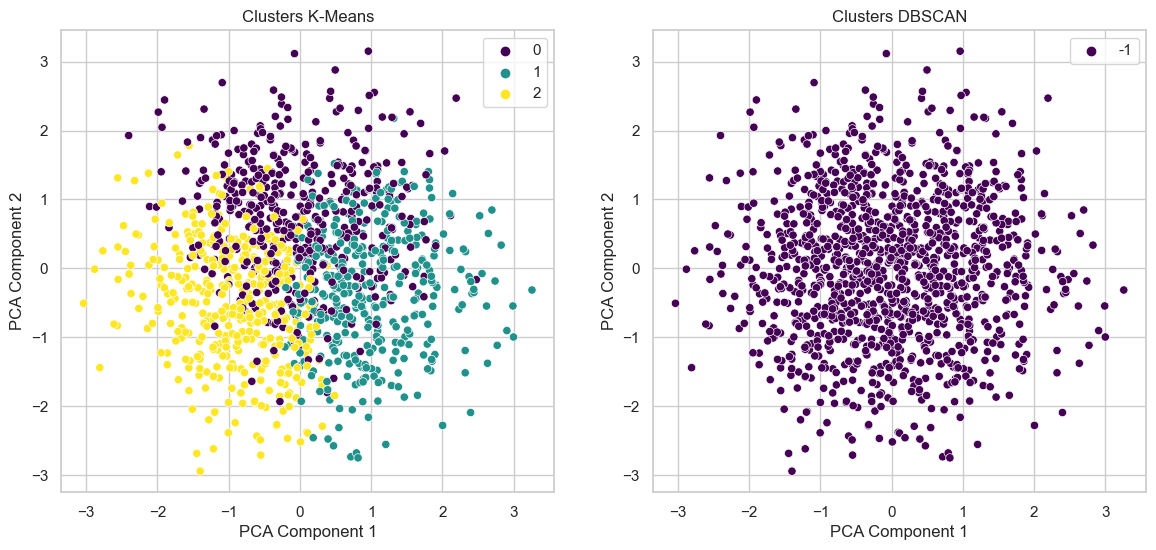

Características médias por cluster (K-Means):
                Transmissor de Vazao de H2O  \
Cluster_KMeans                                
0                              10983.360924   
1                              12372.429011   
2                               5947.590715   

                Totalizador de Vazao FT110003 - TOTALIZADO  \
Cluster_KMeans                                               
0                                             34353.922243   
1                                             31336.967532   
2                                             26616.337136   

                Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO  \
Cluster_KMeans                                                                       
0                                                        0.374766                    
1                                                        0.354156                    
2                                                        0.3689

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_simulacoes seja o DataFrame com os dados simulados

# 1. Normalização dos dados
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_simulacoes)

# 2. Aplicando K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_normalized)

# Aplicando DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(df_normalized)

# Adicionando os clusters ao DataFrame original para análise
df_simulacoes['Cluster_KMeans'] = clusters_kmeans
df_simulacoes['Cluster_DBSCAN'] = clusters_dbscan

# 3. Analisando os clusters

# Redução de dimensionalidade para visualização com PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized)

plt.figure(figsize=(14, 6))

# Visualizando os clusters formados pelo K-Means
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=clusters_kmeans, palette='viridis')
plt.title('Clusters K-Means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Visualizando os clusters formados pelo DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=clusters_dbscan, palette='viridis')
plt.title('Clusters DBSCAN')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

# Analisando as características médias por cluster
print("Características médias por cluster (K-Means):")
print(df_simulacoes.groupby('Cluster_KMeans').mean())

print("\nCaracterísticas médias por cluster (DBSCAN):")
print(df_simulacoes.groupby('Cluster_DBSCAN').mean())


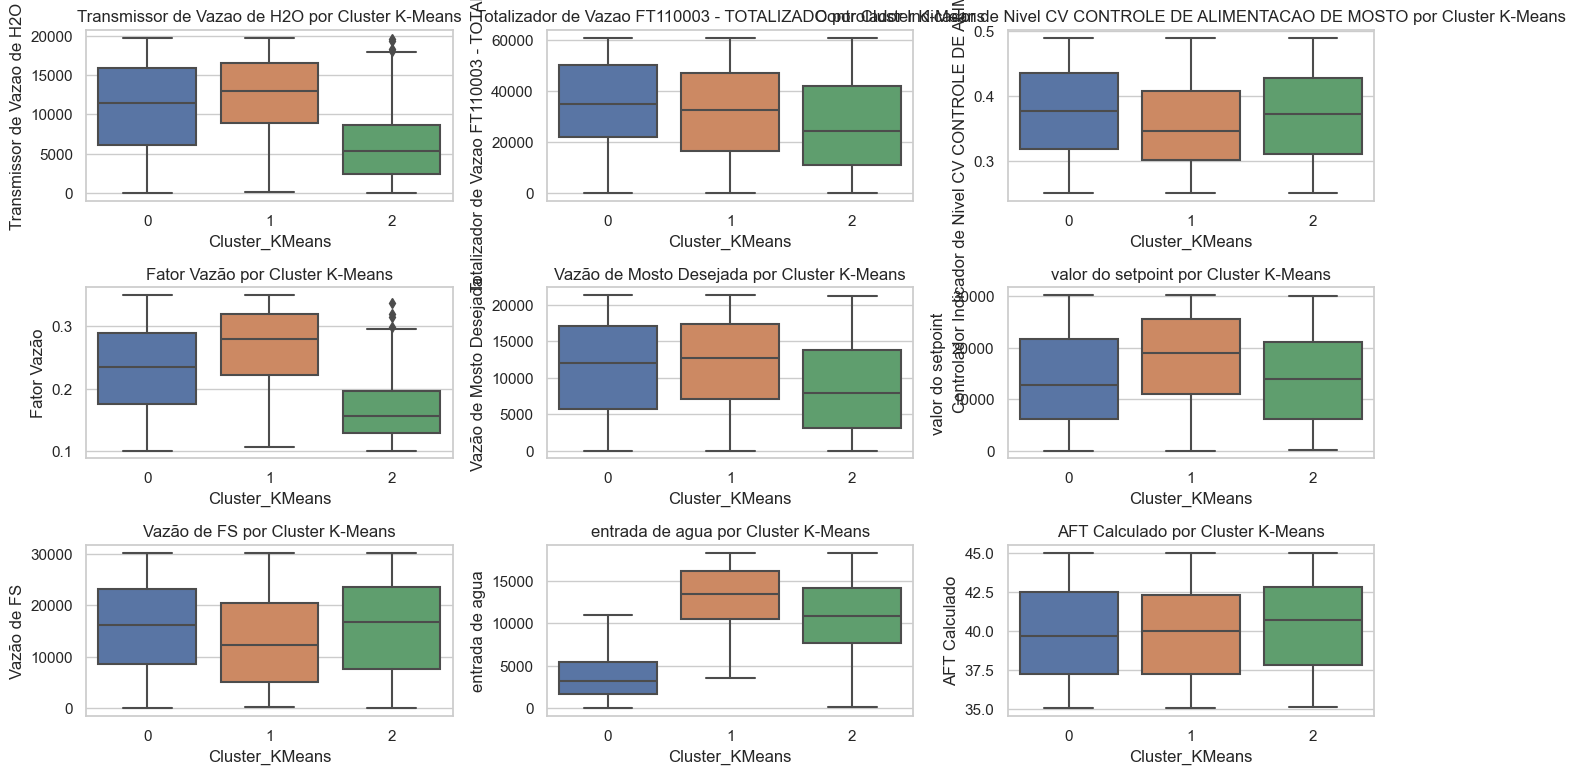

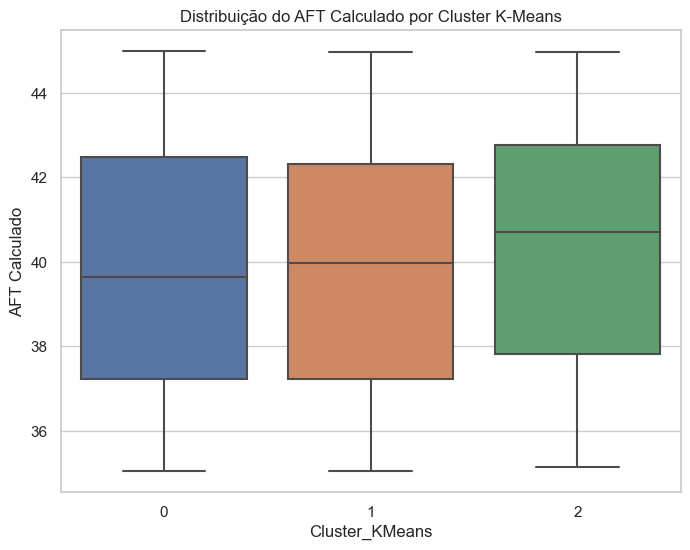

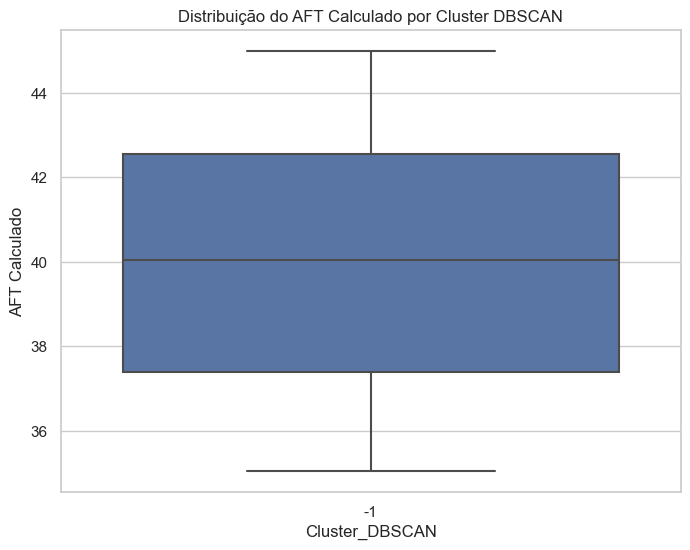

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot para cada característica por cluster (K-Means)
plt.figure(figsize=(14, 10))
for i, column in enumerate(df_simulacoes.columns[:-2], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Cluster_KMeans', y=column, data=df_simulacoes)
    plt.title(f'{column} por Cluster K-Means')
plt.tight_layout()
plt.show()

# Distribuição do AFT Calculado por Cluster K-Means
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster_KMeans', y='AFT Calculado', data=df_simulacoes)
plt.title('Distribuição do AFT Calculado por Cluster K-Means')
plt.show()

# Distribuição do AFT Calculado por Cluster DBSCAN
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster_DBSCAN', y='AFT Calculado', data=df_simulacoes)
plt.title('Distribuição do AFT Calculado por Cluster DBSCAN')
plt.show()


#### Os clusters K-Means identificaram três grupos distintos com diferentes características de vazão e controle, enquanto o DBSCAN identificou um único cluster (-1), que parece ser uma combinação dos clusters K-Means. Isso pode indicar que os dados têm uma estrutura mais clara para o K-Means do que para o DBSCAN, ou que o DBSCAN não conseguiu identificar clusters distintos devido à densidade dos dados.

In [91]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Supondo que df_simulacoes seja o DataFrame com seus dados
# Exemplo de dados fictícios
df_simulacoes = pd.DataFrame({
    'Vazão de FS': np.random.rand(100) * 100,
    'entrada de agua': np.random.rand(100) * 100,
    'valor do setpoint': np.random.rand(100) * 100,
    'Transmissor de Vazao de H2O': np.random.rand(100) * 100,
    'Totalizador de Vazao FT110003 - TOTALIZADO': np.random.rand(100) * 100,
    'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO': np.random.rand(100),
    'Fator Vazão': np.random.rand(100),
    'Vazão de Mosto Desejada': np.random.rand(100) * 100,
    'AFT Calculado': np.random.rand(100) * 100
})

# Definindo as variáveis independentes (X) e a variável dependente (y)
X = df_simulacoes[['Vazão de FS', 'entrada de agua', 'valor do setpoint', 'Transmissor de Vazao de H2O',
                   'Totalizador de Vazao FT110003 - TOTALIZADO', 'Controlador Indicador de Nivel CV CONTROLE DE ALIMENTACAO DE MOSTO',
                   'Fator Vazão', 'Vazão de Mosto Desejada']]
y = df_simulacoes['AFT Calculado']

# Treinando o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Agora você pode chamar a função simular_cenarios
df_cenarios = simular_cenarios(modelo, df_simulacoes, variaveis=['Vazão de FS', 'entrada de agua', 'valor do setpoint'], aft_desejado=37.0)

# Exibir os cenários simulados que atendem ao AFT desejado
print(df_cenarios)


     Vazão de FS  entrada de agua  valor do setpoint  \
19      4.340078        12.162909          99.725553   
61      4.340078        66.141469          11.311286   
68      4.340078        66.141469          88.673770   
78      4.340078        76.937181          88.673770   
113    14.923750        12.162909          33.414853   
122    14.923750        22.958621          22.363069   
150    14.923750        55.345757           0.259502   
154    14.923750        55.345757          44.466636   
156    14.923750        55.345757          66.570203   
204    25.507422         1.367196          44.466636   
230    25.507422        33.754333           0.259502   
235    25.507422        33.754333          55.518420   
243    25.507422        44.550045          33.414853   
247    25.507422        44.550045          77.621987   
268    25.507422        66.141469          88.673770   
275    25.507422        76.937181          55.518420   
279    25.507422        76.937181          99.72

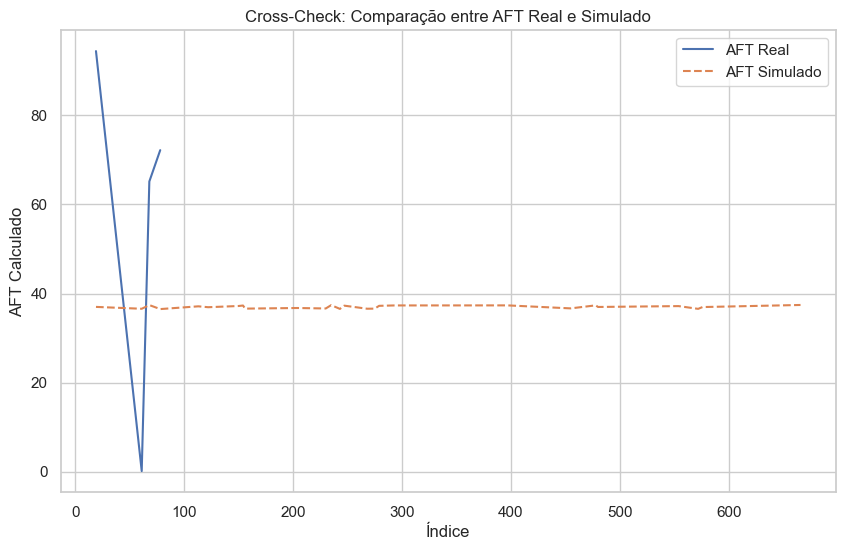

Diferença média: -21.10633256764043
Erro médio absoluto: 39.331420825964145
      AFT Real  AFT Simulado  Diferenca
19   94.430363     36.991651 -57.438713
61    0.123184     36.573360  36.450177
68   65.151947     37.401285 -27.750661
78   72.188763     36.502630 -35.686133
113        NaN     37.119797        NaN
122        NaN     36.921952        NaN
150        NaN     37.193889        NaN
154        NaN     37.301361        NaN
156        NaN     36.605328        NaN
204        NaN     36.743279        NaN
230        NaN     36.637016        NaN
235        NaN     37.388624        NaN
243        NaN     36.543642        NaN
247        NaN     37.270428        NaN
268        NaN     36.582344        NaN
275        NaN     36.601305        NaN
279        NaN     37.232084        NaN
293        NaN     37.318954        NaN
397        NaN     37.331215        NaN
455        NaN     36.658843        NaN
478        NaN     37.340065        NaN
480        NaN     36.976447        NaN
554 

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# Função para realizar cross-check entre cenários simulados e valores reais
def cross_check(df_real, df_simulado):
    # Comparar valores reais e simulados de AFT
    comparacao = pd.DataFrame({
        'AFT Real': df_real['AFT Calculado'],
        'AFT Simulado': df_simulado['AFT Calculado']
    })
    
    # Plotar a comparação
    plt.figure(figsize=(10, 6))
    plt.plot(comparacao['AFT Real'], label='AFT Real')
    plt.plot(comparacao['AFT Simulado'], label='AFT Simulado', linestyle='--')
    plt.xlabel('Índice')
    plt.ylabel('AFT Calculado')
    plt.title('Cross-Check: Comparação entre AFT Real e Simulado')
    plt.legend()
    plt.show()

    # Calcular diferença média e erro
    comparacao['Diferenca'] = comparacao['AFT Simulado'] - comparacao['AFT Real']
    diferenca_media = comparacao['Diferenca'].mean()
    erro_medio_absoluto = comparacao['Diferenca'].abs().mean()

    print(f"Diferença média: {diferenca_media}")
    print(f"Erro médio absoluto: {erro_medio_absoluto}")
    
    return comparacao

# Supondo que você tenha uma coluna 'ID' comum em ambos os DataFrames
df_simulacoes['ID'] = df_simulacoes.index
df_cenarios['ID'] = df_cenarios.index

# Executar o cross-check
df_real = df_simulacoes[df_simulacoes['ID'].isin(df_cenarios['ID'])]
comparacao = cross_check(df_real, df_cenarios)

# Análise dos resultados
print(comparacao)
